# Protein Ligant Prediction

## Data Set - Link and Node apo CSV files with ground_truth

In [5]:
import numpy as np
import os
import pandas as pd
import random

def get_file_summary(file_path):
    data = pd.read_csv(file_path)
    summary = {
        "Number of Rows": len(data),
        "Number of Columns": len(data.columns)
    }
    return summary


apo_folder = 'apo'


node_files = [f for f in os.listdir(apo_folder) if f.endswith('_nodes.csv')]
link_files = [f for f in os.listdir(apo_folder) if f.endswith('_links.csv')]


if len(node_files) < 5 or len(link_files) < 5:
    print("Not enough files to select 5 pairs.")
else:
    
    selected_node_files = random.sample(node_files, 5)
    selected_link_files = [f.replace('_nodes.csv', '_links.csv') for f in selected_node_files]

    for node_file, link_file in zip(selected_node_files, selected_link_files):
        node_summary = get_file_summary(os.path.join(apo_folder, node_file))
        link_summary = get_file_summary(os.path.join(apo_folder, link_file))

        print(f"Node File: {node_file}, Summary: {node_summary}")
        print(f"Link File: {link_file}, Summary: {link_summary}")
        print("-" * 40)


KeyboardInterrupt: 

## Processing of Data

- Removing of redundant columns
- Adding bidirectional and self links
- creating graph structures

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
import os

def load_and_process_data(prefix):
    node_file = f'apo/{prefix}_nodes.csv'
    link_file = f'apo/{prefix}_links.csv'

    node_data = pd.read_csv(node_file)
    link_data = pd.read_csv(link_file)


    labels = node_data['ground_truth'].values
    features = node_data.drop(columns=['ground_truth'])

    node_features = node_data[['atom_type', 'residue_type', 'center_x', 'center_y', 'center_z', 'radius', 'voromqa_sas_potential', 'residue_mean_sas_potential', 'residue_sum_sas_potential', 'residue_size', 'sas_area', 'solvdir_x', 'solvdir_y', 'solvdir_z', 'voromqa_sas_energy', 'voromqa_depth', 'voromqa_score_a', 'voromqa_score_r', 'volume', 'volume_vdw', 'ufsr_a1', 'ufsr_a2', 'ufsr_c2', 'ufsr_c3', 'ev28', 'ev56', 'ground_truth']]

    link_features = link_data[['atom_index1', 'atom_index2','area', 'boundary', 'distance', 'voromqa_energy', 'seq_sep_class', 'covalent_bond', 'hbond']]


    edge_index = torch.tensor(np.array([link_features['atom_index1'].values, link_features['atom_index2'].values]), dtype=torch.long)


    self_links = torch.arange(0, len(node_features))
    edge_index = torch.cat([edge_index, torch.stack([self_links, self_links])], dim=1)
    edge_index = torch.cat([edge_index, edge_index[[1, 0], :]], dim=1)  

    node_features_tensor = torch.tensor(node_features.values, dtype=torch.float)
    labels_tensor = torch.tensor(labels, dtype=torch.float)

    
    data = Data(x=node_features_tensor, edge_index=edge_index, y=labels_tensor)

    return data


candidate_pairs_file = 'apo/candidate_pairs.txt'
candidate_pairs = pd.read_csv(candidate_pairs_file, delim_whitespace=True)


graphs = {}
for index, row in candidate_pairs.iterrows():
    prefix = f"{row['apo_pdb_id']}_{row['apo_chain_id']}"
    graphs[prefix] = load_and_process_data(prefix)



save_dir = 'saved_graphs'
os.makedirs(save_dir, exist_ok=True)


for prefix, graph in graphs.items():
    save_path = os.path.join(save_dir, f'{prefix}_graph.pt')
    torch.save(graph, save_path)

print(f"All graphs have been saved in the directory: {save_dir}")

All graphs have been saved in the directory: saved_graphs


# Representation of Created Graphs

In [ ]:
import os
import torch
import random

def get_graph_summary(file_path):
    graph = torch.load(file_path)
    summary = {
        "Number of Nodes": graph.num_nodes,
        "Number of Edges": graph.num_edges,
        "Feature Vector Size per Node": graph.num_node_features
    }
    return summary


saved_graphs_folder = 'sh'


graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]


if len(graph_files) < 5:
    print("Not enough files to select 5 graphs.")
else:
  
    selected_graph_files = random.sample(graph_files, 5)

    for graph_file in selected_graph_files:
        graph_summary = get_graph_summary(os.path.join(saved_graphs_folder, graph_file))
        print(f"Graph File: {graph_file}, Summary: {graph_summary}")
        print("-" * 40)


Graph File: 2AL4_F_graph.pt, Summary: {'Number of Nodes': 2018, 'Number of Edges': 32714, 'Feature Vector Size per Node': 20}
----------------------------------------
Graph File: 2OT1_D_graph.pt, Summary: {'Number of Nodes': 2666, 'Number of Edges': 43568, 'Feature Vector Size per Node': 20}
----------------------------------------
Graph File: 3CFN_B_graph.pt, Summary: {'Number of Nodes': 883, 'Number of Edges': 13866, 'Feature Vector Size per Node': 20}
----------------------------------------
Graph File: 5IGY_A_graph.pt, Summary: {'Number of Nodes': 2385, 'Number of Edges': 38680, 'Feature Vector Size per Node': 20}
----------------------------------------
Graph File: 1GRN_A_graph.pt, Summary: {'Number of Nodes': 1379, 'Number of Edges': 22080, 'Feature Vector Size per Node': 20}
----------------------------------------


# Visualization of a random created Protein Graph

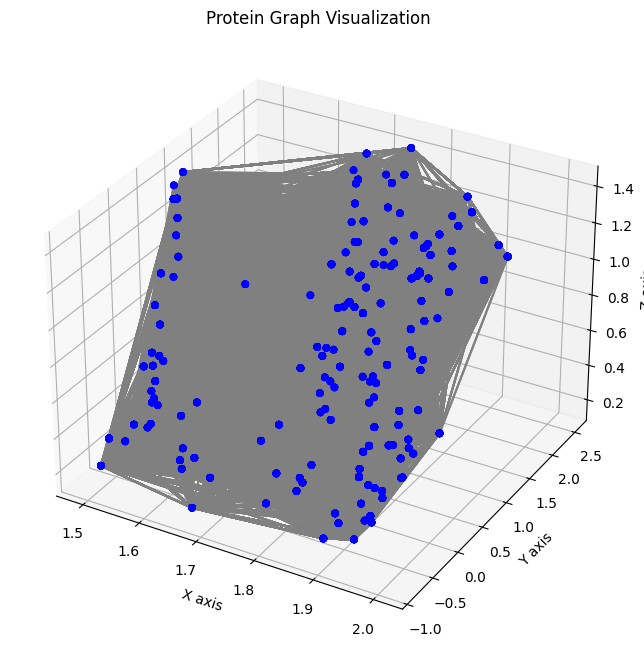

In [ ]:
import os
import random
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_protein_graph(graph):
 
    pos = graph.x[:, 2:5]  


    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=20, c='blue')


    for edge in graph.edge_index.t():
        start, end = edge[0].item(), edge[1].item()
        xs, ys, zs = zip(pos[start], pos[end])
        ax.plot(xs, ys, zs, color='gray')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    plt.title("Protein Graph Visualization")
    plt.show()


saved_graphs_folder = 'sg'


graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]


selected_graph_file = random.choice(graph_files)


graph_path = os.path.join(saved_graphs_folder, selected_graph_file)
graph = torch.load(graph_path)


plot_protein_graph(graph)


/home/flahaari/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Fold 129: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


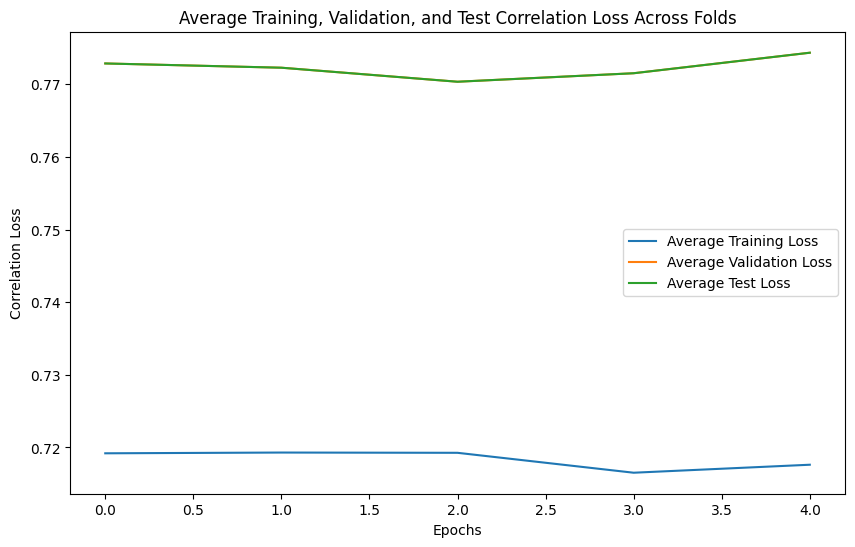

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader
import gvp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
from scipy.stats import pearsonr


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class GVP_RNN_Model(nn.Module):
    def __init__(self, scalar_feature_indices, vector_feature_indices, node_out_dims, dropout_rate=0.5):
        super(GVP_RNN_Model, self).__init__()
        self.scalar_feature_indices = scalar_feature_indices
        self.vector_feature_indices = vector_feature_indices
        scalar_in = len(scalar_feature_indices)
        vector_in = len(vector_feature_indices) // 3

        node_in_dims = (scalar_in, vector_in)
        self.gvp1 = gvp.GVP(node_in_dims, (node_out_dims, node_out_dims // 3), vector_gate=True, activations=(nn.ReLU(), None))
        self.dropout = nn.Dropout(dropout_rate)
        self.gvp2 = gvp.GVP((node_out_dims, node_out_dims // 3), (1, 0))

    def forward(self, data):
        scalar_x = data.x[:, self.scalar_feature_indices]
        vector_x = data.x[:, self.vector_feature_indices].view(-1, len(self.vector_feature_indices) // 3, 3)

        x = (scalar_x, vector_x)
        x = self.gvp1(x)
        x = self.dropout(x[0]), x[1]
        x = self.gvp2(x)


        if x[0].shape[0] == data.x.shape[0]:
            x = geom_nn.global_mean_pool(x[0], data.batch)
        return x


def correlation_loss(y_pred, y_true):
    centered_y_pred = y_pred - torch.mean(y_pred)
    centered_y_true = y_true - torch.mean(y_true)

    denominator = torch.sqrt(torch.sum(centered_y_pred ** 2)) * torch.sqrt(torch.sum(centered_y_true ** 2))
    epsilon = 1e-8
    denominator = torch.clamp(denominator, min=epsilon)

    correlation = torch.sum(centered_y_pred * centered_y_true) / denominator

    loss = 1 - correlation
    return loss


def leave_one_out_cross_validation(datasets, model, optimizer, criterion, batch_size=64):
    loo = LeaveOneOut()

    all_train_loss_history = []
    all_val_loss_history = []
    all_test_loss_history = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for fold, (train_index, val_index) in enumerate(loo.split(datasets)):
        train_data = [datasets[i] for i in train_index]
        val_data = datasets[val_index[0]]

        model.to(device)
        model.train()

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader([val_data], batch_size=batch_size, shuffle=False)

        train_loss_history = []
        val_loss_history = []
        test_loss_history = []

        for epoch in tqdm(range(epochs), desc=f"Fold {fold+1}"):
            total_train_loss = 0

          
            model.train()
            for batch_data in train_loader:
                batch_data = batch_data.to(device)
                optimizer.zero_grad()
                output = model(batch_data)

                output = output.squeeze()
                loss = correlation_loss(output, batch_data.y)

                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            train_loss_history.append(avg_train_loss)

      
            model.eval()
            with torch.no_grad():
                total_val_loss = 0
                for batch_data in val_loader:
                    batch_data = batch_data.to(device)
                    output = model(batch_data)
                    output = output.squeeze()
                    loss = correlation_loss(output, batch_data.y)
                    total_val_loss += loss.item()
                avg_val_loss = total_val_loss / len(val_loader)
                val_loss_history.append(avg_val_loss)

            
            test_data_loader = DataLoader([val_data], batch_size=1, shuffle=False)
            total_test_loss = 0
            model.eval()
            with torch.no_grad():
                for batch_data in test_data_loader:
                    batch_data = batch_data.to(device)
                    output = model(batch_data)
                    output = output.squeeze()
                    loss = correlation_loss(output, batch_data.y)
                    total_test_loss += loss.item()
                avg_test_loss = total_test_loss / len(test_data_loader)
                test_loss_history.append(avg_test_loss)

        all_train_loss_history.append(train_loss_history)
        all_val_loss_history.append(val_loss_history)
        all_test_loss_history.append(test_loss_history)

    return all_train_loss_history, all_val_loss_history, all_test_loss_history


def load_graph_data():

    saved_graphs_folder = 'saved_graphs2'
    graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]
    datasets = [torch.load(os.path.join(saved_graphs_folder, f)) for f in graph_files]
    return datasets

scalar_feature_indices = [0, 1, 5, 7, 8, 9, 10, 18, 19, 20, 21, 22, 23, 24, 25, 6, 14, 15, 16, 17]
vector_feature_indices = [11, 12, 13, 2, 3, 4]
node_out_dims = 32
epochs = 5
batch_size = 64


datasets = load_graph_data()


model = GVP_RNN_Model(scalar_feature_indices, vector_feature_indices, node_out_dims)
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_loss_history, val_loss_history, test_loss_history = leave_one_out_cross_validation(datasets, model, optimizer, correlation_loss, batch_size=batch_size)


avg_train_loss_history = np.mean(train_loss_history, axis=0)
avg_val_loss_history = np.mean(val_loss_history, axis=0)
avg_test_loss_history = np.mean(test_loss_history, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(avg_train_loss_history, label='Average Training Loss')
plt.plot(avg_test_loss_history, label='Average Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Correlation Loss')
plt.title('Average Training, Validation, and Test Correlation Loss Across Folds')
plt.ylim(0, max(max(avg_train_loss_history), max(avg_val_loss_history), max(avg_test_loss_history)))
plt.legend()
plt.show()



Fold 129: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


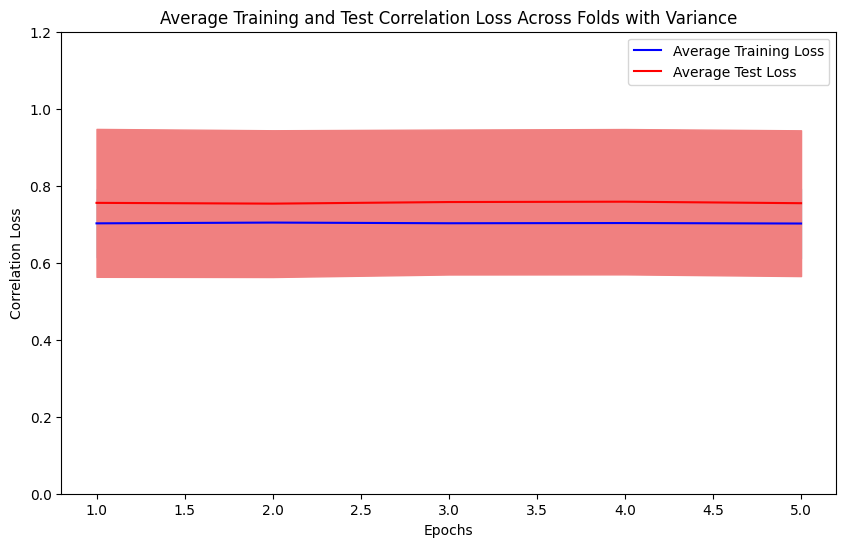

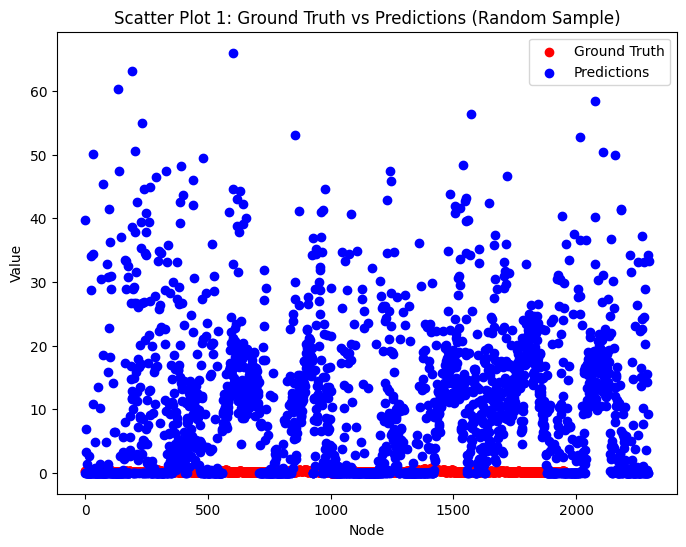

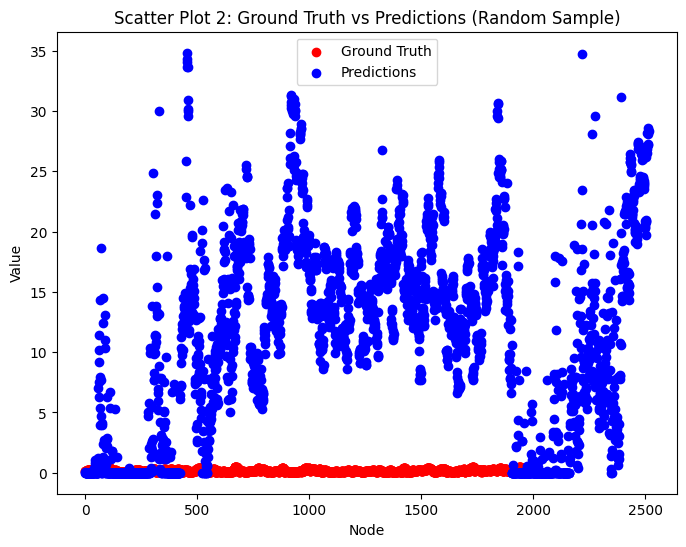

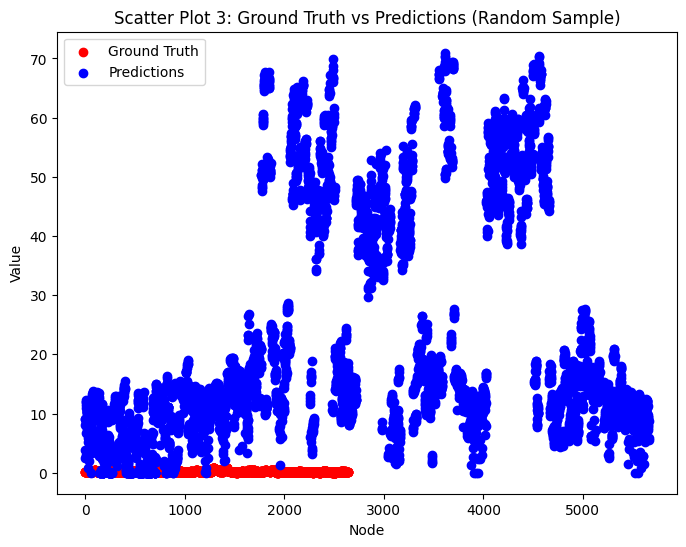

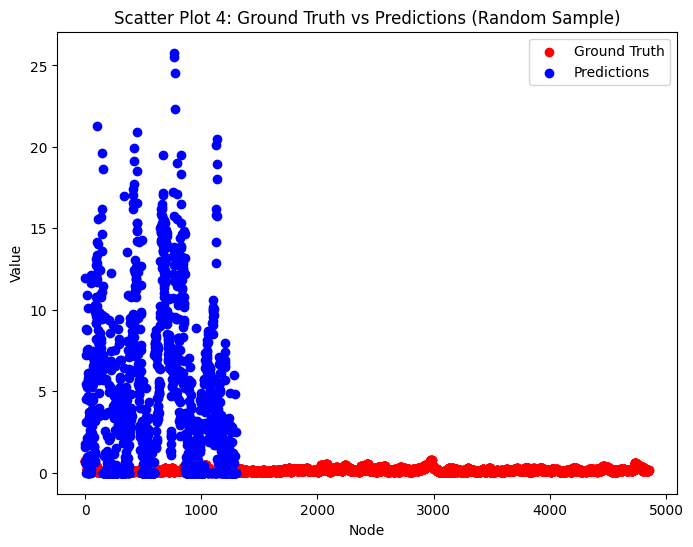

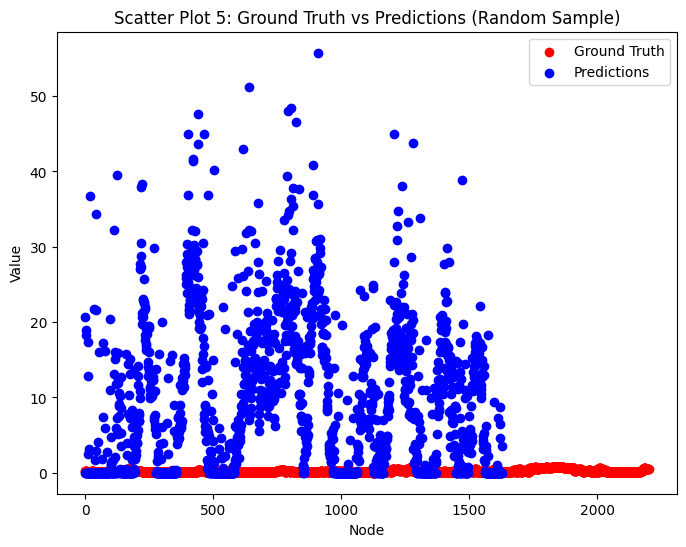

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader
import gvp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
from scipy.stats import pearsonr
import random


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_graph_data():

    saved_graphs_folder = 'saved_graphs2'
    graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]
    datasets = [torch.load(os.path.join(saved_graphs_folder, f)) for f in graph_files]
    return datasets


class GVP_RNN_Model(nn.Module):
    def __init__(self, scalar_feature_indices, vector_feature_indices, node_out_dims, dropout_rate=0.5):
        super(GVP_RNN_Model, self).__init__()
        self.scalar_feature_indices = scalar_feature_indices
        self.vector_feature_indices = vector_feature_indices
        scalar_in = len(scalar_feature_indices)
        vector_in = len(vector_feature_indices) // 3

        node_in_dims = (scalar_in, vector_in)
        self.gvp1 = gvp.GVP(node_in_dims, (node_out_dims, node_out_dims // 3), vector_gate=True, activations=(nn.ReLU(), None))
        self.dropout = nn.Dropout(dropout_rate)
        self.gvp2 = gvp.GVP((node_out_dims, node_out_dims // 3), (1, 0))

    def forward(self, data):
        scalar_x = data.x[:, self.scalar_feature_indices]
        vector_x = data.x[:, self.vector_feature_indices].view(-1, len(self.vector_feature_indices) // 3, 3)

        x = (scalar_x, vector_x)
        x = self.gvp1(x)
        x = self.dropout(x[0]), x[1]
        x = self.gvp2(x)

        if x[0].shape[0] == data.x.shape[0]:
            x = geom_nn.global_mean_pool(x[0], data.batch)
        return x


def correlation_loss(y_pred, y_true):
    centered_y_pred = y_pred - torch.mean(y_pred)
    centered_y_true = y_true - torch.mean(y_true)

    denominator = torch.sqrt(torch.sum(centered_y_pred ** 2)) * torch.sqrt(torch.sum(centered_y_true ** 2))
    epsilon = 1e-8
    denominator = torch.clamp(denominator, min=epsilon)

    correlation = torch.sum(centered_y_pred * centered_y_true) / denominator

    loss = 1 - correlation
    return loss

def leave_one_out_cross_validation(datasets, model, optimizer, criterion, batch_size=64):
    loo = LeaveOneOut()

    all_train_loss_history = []
    all_val_loss_history = []
    all_test_loss_history = []
    all_predictions = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for fold, (train_index, val_index) in enumerate(loo.split(datasets)):
        train_data = [datasets[i] for i in train_index]
        val_data = datasets[val_index[0]]

        model.to(device)
        model.train()

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader([val_data], batch_size=batch_size, shuffle=False)

        train_loss_history = []
        val_loss_history = []
        test_loss_history = []

        for epoch in tqdm(range(epochs), desc=f"Fold {fold+1}"):
            total_train_loss = 0

            model.train()
            for batch_data in train_loader:
                batch_data = batch_data.to(device)
                optimizer.zero_grad()
                output = model(batch_data)

                output = output.squeeze()
                loss = criterion(output, batch_data.y)

                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            train_loss_history.append(avg_train_loss)


            model.eval()
            with torch.no_grad():
                total_val_loss = 0
                for batch_data in val_loader:
                    batch_data = batch_data.to(device)
                    output = model(batch_data)
                    output = output.squeeze()
                    loss = criterion(output, batch_data.y)
                    total_val_loss += loss.item()
                avg_val_loss = total_val_loss / len(val_loader)
                val_loss_history.append(avg_val_loss)


            test_data_loader = DataLoader([val_data], batch_size=1, shuffle=False)
            total_test_loss = 0
            predictions = []
            model.eval()
            with torch.no_grad():
                for batch_data in test_data_loader:
                    batch_data = batch_data.to(device)
                    output = model(batch_data)
                    output = output.squeeze()
                    loss = criterion(output, batch_data.y)
                    total_test_loss += loss.item()
                    predictions.append(output.cpu().numpy())
                avg_test_loss = total_test_loss / len(test_data_loader)
                test_loss_history.append(avg_test_loss)
            
            all_predictions.append(predictions)

        all_train_loss_history.append(train_loss_history)
        all_val_loss_history.append(val_loss_history)
        all_test_loss_history.append(test_loss_history)

    return all_train_loss_history, all_val_loss_history, all_test_loss_history, all_predictions


scalar_feature_indices = [0, 1, 5, 7, 8, 9, 10, 18, 19, 20, 21, 22, 23, 24, 25, 6, 14, 15, 16, 17]
vector_feature_indices = [11, 12, 13, 2, 3, 4]
node_out_dims = 32
epochs = 5
batch_size = 64


datasets = load_graph_data()


model = GVP_RNN_Model(scalar_feature_indices, vector_feature_indices, node_out_dims)
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_loss_history, val_loss_history, test_loss_history, all_predictions = leave_one_out_cross_validation(datasets, model, optimizer, correlation_loss, batch_size=batch_size)


avg_train_loss_history = np.mean(train_loss_history, axis=0)
std_train_loss_history = np.std(train_loss_history, axis=0)
avg_test_loss_history = np.mean(test_loss_history, axis=0)
std_test_loss_history = np.std(test_loss_history, axis=0)


plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), avg_train_loss_history, label='Average Training Loss', color='blue')
plt.fill_between(range(1, epochs+1), avg_train_loss_history - std_train_loss_history, avg_train_loss_history + std_train_loss_history, color='lightblue')
plt.plot(range(1, epochs+1), avg_test_loss_history, label='Average Test Loss', color='red')
plt.fill_between(range(1, epochs+1), avg_test_loss_history - std_test_loss_history, avg_test_loss_history + std_test_loss_history, color='lightcoral')
plt.xlabel('Epochs')
plt.ylabel('Correlation Loss')
plt.title('Average Training and Test Correlation Loss Across Folds with Variance')
plt.legend()
plt.ylim(0, 1.2)
plt.show()


random_indices = random.sample(range(len(datasets)), 5)
for i, index in enumerate(random_indices, 1):
    ground_truth = datasets[index].y.cpu().numpy()
    predictions = all_predictions[index][-1]

    plt.figure(figsize=(8, 6))
    plt.scatter(range(len(ground_truth)), ground_truth, color='red', label='Ground Truth')
    plt.scatter(range(len(predictions)), predictions, color='blue', label='Predictions')
    plt.xlabel('Node')
    plt.ylabel('Value')
    plt.title(f'Scatter Plot {i}: Ground Truth vs Predictions (Random Sample)')
    plt.legend()
    plt.show()


Fold 1:   0%|          | 0/800 [00:00<?, ?it/s]

Fold 129: 100%|██████████| 800/800 [06:13<00:00,  2.14it/s]


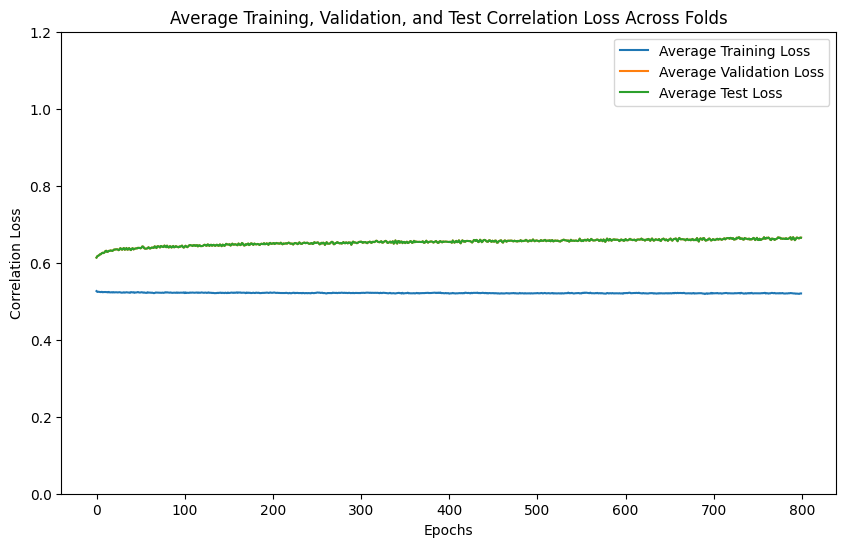

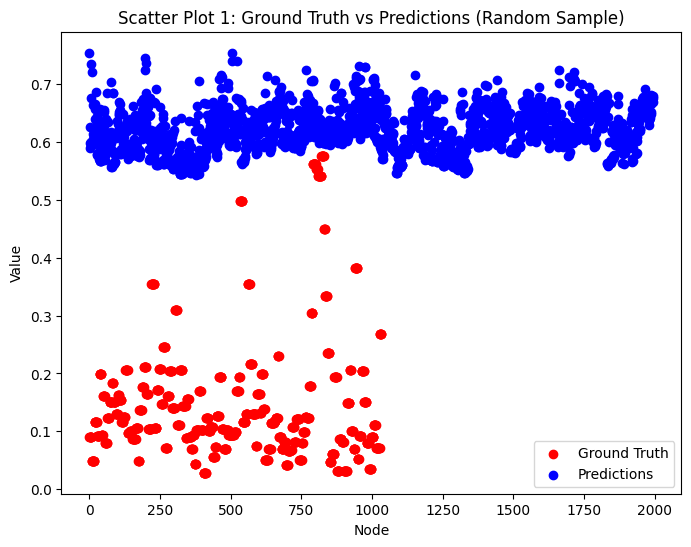

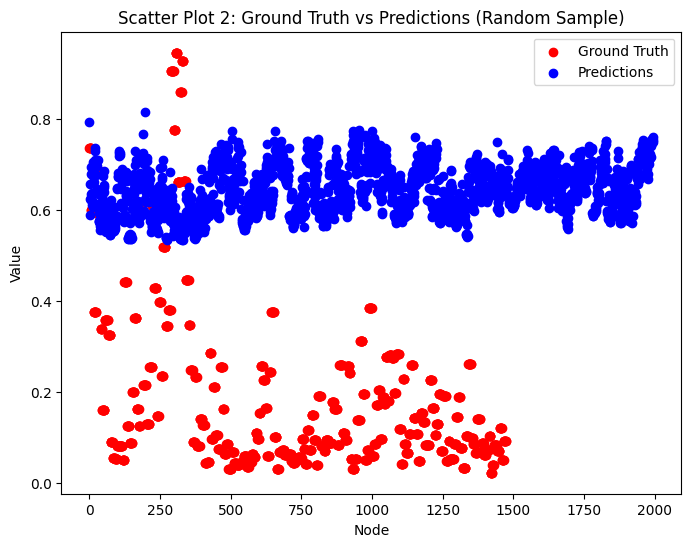

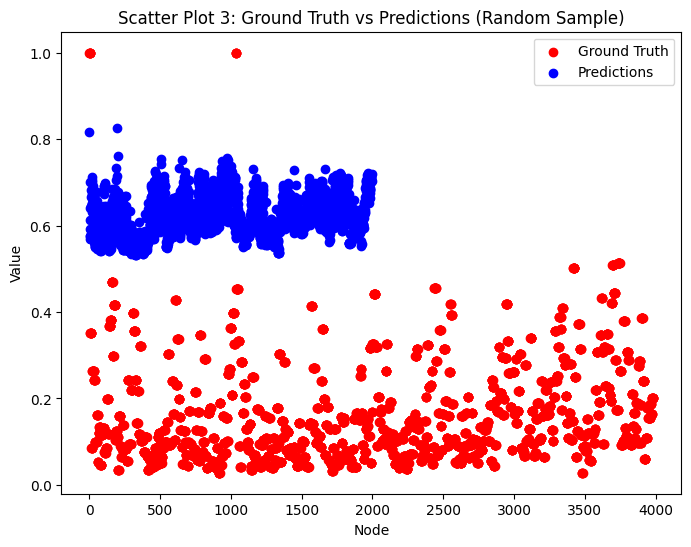

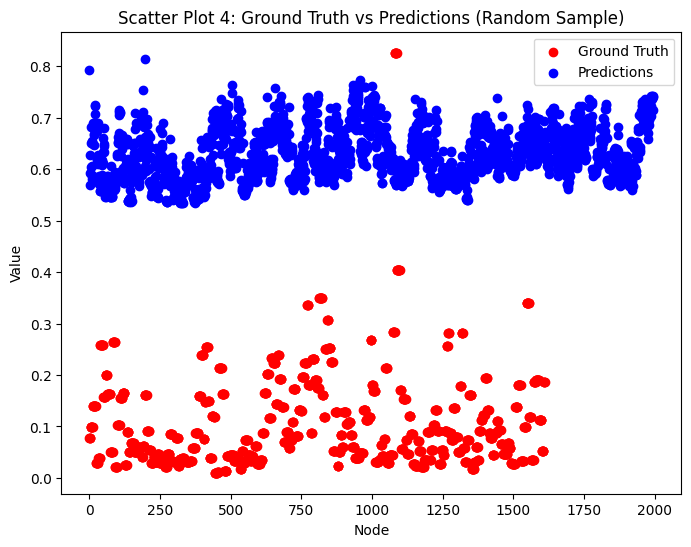

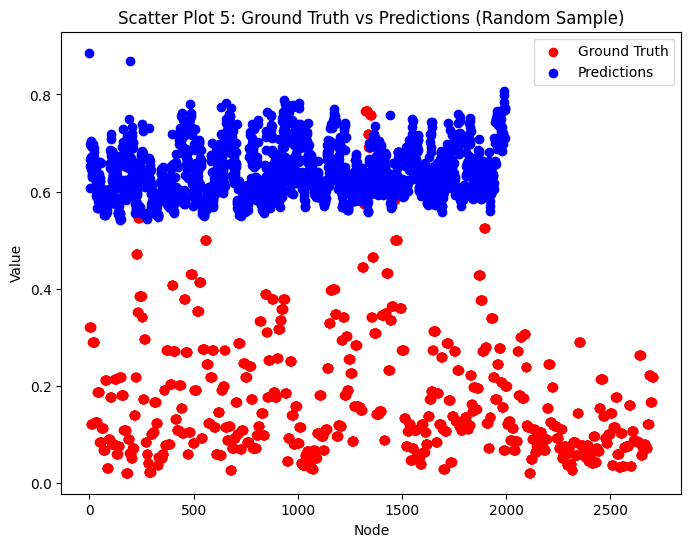

In [ ]:
import os
import shutil
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader
import gvp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
from scipy.stats import pearsonr
from torch_geometric.nn import global_mean_pool
import random


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_graph_data():
   
    saved_graphs_folder = 'saved_graphs2'
    graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]
    datasets = [torch.load(os.path.join(saved_graphs_folder, f)) for f in graph_files]
    return datasets

class GVP_RNN_Model(nn.Module):
    def __init__(self, scalar_feature_indices, vector_feature_indices, node_out_dims, dropout_rate=0.5):
        super(GVP_RNN_Model, self).__init__()
        self.scalar_feature_indices = scalar_feature_indices
        self.vector_feature_indices = vector_feature_indices
        scalar_in = len(scalar_feature_indices)
        vector_in = len(vector_feature_indices) // 3

        node_in_dims = (scalar_in, vector_in)
        self.gvp1 = gvp.GVP(node_in_dims, (node_out_dims, node_out_dims // 3), vector_gate=True, activations=(nn.ReLU(), None))
        self.bn1 = nn.BatchNorm1d(node_out_dims)  
        self.dropout = nn.Dropout(dropout_rate)
        self.gvp2 = gvp.GVP((node_out_dims, node_out_dims // 3), (node_out_dims, node_out_dims // 3), vector_gate=True, activations=(nn.ReLU(), None))
        self.final_linear = nn.Linear(node_out_dims, 1)  
        self.sigmoid = nn.Sigmoid()

    def forward(self, data):
        scalar_x = data.x[:, self.scalar_feature_indices]
        vector_x = data.x[:, self.vector_feature_indices].view(-1, len(self.vector_feature_indices) // 3, 3)

        x = (scalar_x, vector_x)
        x = self.gvp1(x)
        x = (self.bn1(x[0]), x[1]) 
        x = (self.dropout(x[0]), x[1])
        
        x = self.gvp2(x)
        x = self.final_linear(x[0])  
        
        x = self.sigmoid(x)  

     
        x = x.squeeze(-1) 

        return x





def correlation_loss(y_pred, y_true):
    centered_y_pred = y_pred - torch.mean(y_pred)
    centered_y_true = y_true - torch.mean(y_true)

    denominator = torch.sqrt(torch.sum(centered_y_pred ** 2)) * torch.sqrt(torch.sum(centered_y_true ** 2))
    epsilon = 1e-8
    denominator = torch.clamp(denominator, min=epsilon)

    correlation = torch.sum(centered_y_pred * centered_y_true) / denominator

    loss = 1 - correlation
    return loss


def leave_one_out_cross_validation(datasets, model, optimizer, criterion, batch_size=64):
    loo = LeaveOneOut()

    all_train_loss_history = []
    all_val_loss_history = []
    all_test_loss_history = []
    all_predictions = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for fold, (train_index, val_index) in enumerate(loo.split(datasets)):
        train_data = [datasets[i] for i in train_index]
        val_data = datasets[val_index[0]]

        model.to(device)
        model.train()

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader([val_data], batch_size=batch_size, shuffle=False)

        train_loss_history = []
        val_loss_history = []
        test_loss_history = []

        for epoch in tqdm(range(epochs), desc=f"Fold {fold+1}"):
            total_train_loss = 0

           
            model.train()
            for batch_data in train_loader:
                batch_data = batch_data.to(device)
                optimizer.zero_grad()
                output = model(batch_data)

                output = output.squeeze()
                loss = criterion(output, batch_data.y)

                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            train_loss_history.append(avg_train_loss)

            
            model.eval()
            with torch.no_grad():
                total_val_loss = 0
                for batch_data in val_loader:
                    batch_data = batch_data.to(device)
                    output = model(batch_data)
                    output = output.squeeze()
                    loss = criterion(output, batch_data.y)
                    total_val_loss += loss.item()
                avg_val_loss = total_val_loss / len(val_loader)
                val_loss_history.append(avg_val_loss)

           
            test_data_loader = DataLoader([val_data], batch_size=1, shuffle=False)
            total_test_loss = 0
            predictions = []
            model.eval()
            with torch.no_grad():
                for batch_data in test_data_loader:
                    batch_data = batch_data.to(device)
                    output = model(batch_data)
                    output = output.squeeze()
                    loss = criterion(output, batch_data.y)
                    total_test_loss += loss.item()
                    predictions.append(output.cpu().numpy())
                avg_test_loss = total_test_loss / len(test_data_loader)
                test_loss_history.append(avg_test_loss)
            
            all_predictions.append(predictions)

        all_train_loss_history.append(train_loss_history)
        all_val_loss_history.append(val_loss_history)
        all_test_loss_history.append(test_loss_history)

    return all_train_loss_history, all_val_loss_history, all_test_loss_history, all_predictions


scalar_feature_indices = [0, 1, 5, 7, 8, 9, 10, 18, 19, 20, 21, 22, 23, 24, 25, 6, 14, 15, 16, 17]
vector_feature_indices = [11, 12, 13, 2, 3, 4]
node_out_dims = 32
epochs = 800
batch_size = 64


def save_predictions(ground_truth, predictions, filename):
    with open(filename, 'w') as f:
        f.write("Ground Truth\tPredictions\n")
        for gt, pred in zip(ground_truth, predictions):
            f.write(f"{gt:.6f}\t{pred:.6f}\n")


def create_new_preds_folder():
    if os.path.exists('preds'):
        shutil.rmtree('preds')
    os.mkdir('preds')


datasets = load_graph_data()


model = GVP_RNN_Model(scalar_feature_indices, vector_feature_indices, node_out_dims)
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_loss_history, val_loss_history, test_loss_history, all_predictions = leave_one_out_cross_validation(datasets, model, optimizer, correlation_loss, batch_size=batch_size)

avg_train_loss_history = np.mean(train_loss_history, axis=0)
avg_val_loss_history = np.mean(val_loss_history, axis=0)
avg_test_loss_history = np.mean(test_loss_history, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(avg_train_loss_history, label='Average Training Loss')
plt.plot(avg_val_loss_history, label='Average Validation Loss')
plt.plot(avg_test_loss_history, label='Average Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Correlation Loss')
plt.title('Average Training, Validation, and Test Correlation Loss Across Folds')
plt.legend()
plt.ylim(0, max(max(avg_train_loss_history), max(avg_val_loss_history), max(avg_test_loss_history),1.2))
plt.show()


create_new_preds_folder()


for i, predictions in enumerate(all_predictions):
    if i < len(datasets):  
        ground_truth = datasets[i].y.cpu().numpy()
        filename = os.path.join('preds', f'protein_{i}_predictions.txt')
        save_predictions(ground_truth, predictions[-1], filename)


random_indices = random.sample(range(len(datasets)), min(5, len(datasets)))
for i, index in enumerate(random_indices, 1):
    ground_truth = datasets[index].y.cpu().numpy()
    predictions = all_predictions[index][-1] 

    plt.figure(figsize=(8, 6))
    plt.scatter(range(len(ground_truth)), ground_truth, color='red', label='Ground Truth')
    plt.scatter(range(len(predictions)), predictions, color='blue', label='Predictions')
    plt.xlabel('Node')
    plt.ylabel('Value')
    plt.title(f'Scatter Plot {i}: Ground Truth vs Predictions (Random Sample)')
    plt.legend()
    plt.show()


Starting Fold 1/129


Fold 1:   0%|          | 0/200 [00:00<?, ?it/s]/home/flahaari/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Fold 1: 100%|██████████| 200/200 [04:46<00:00,  1.43s/it]


Starting Fold 2/129


Fold 2: 100%|██████████| 200/200 [04:39<00:00,  1.40s/it]


Starting Fold 3/129


Fold 3: 100%|██████████| 200/200 [04:37<00:00,  1.39s/it]


Starting Fold 4/129


Fold 4: 100%|██████████| 200/200 [02:56<00:00,  1.14it/s]


Starting Fold 5/129


Fold 5: 100%|██████████| 200/200 [03:05<00:00,  1.08it/s]


Starting Fold 6/129


Fold 6: 100%|██████████| 200/200 [04:29<00:00,  1.35s/it]


Starting Fold 7/129


Fold 7: 100%|██████████| 200/200 [04:29<00:00,  1.35s/it]


Starting Fold 8/129


Fold 8: 100%|██████████| 200/200 [04:27<00:00,  1.34s/it]


Starting Fold 9/129


Fold 9: 100%|██████████| 200/200 [02:24<00:00,  1.39it/s]


Starting Fold 10/129


Fold 10: 100%|██████████| 200/200 [03:35<00:00,  1.08s/it]


Starting Fold 11/129


Fold 11: 100%|██████████| 200/200 [03:47<00:00,  1.14s/it]


Starting Fold 12/129


Fold 12: 100%|██████████| 200/200 [03:43<00:00,  1.12s/it]


Starting Fold 13/129


Fold 13: 100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Starting Fold 14/129


Fold 14: 100%|██████████| 200/200 [03:53<00:00,  1.17s/it]


Starting Fold 15/129


Fold 15: 100%|██████████| 200/200 [03:47<00:00,  1.14s/it]


Starting Fold 16/129


Fold 16: 100%|██████████| 200/200 [03:49<00:00,  1.15s/it]


Starting Fold 17/129


Fold 17: 100%|██████████| 200/200 [03:45<00:00,  1.13s/it]


Starting Fold 18/129


Fold 18: 100%|██████████| 200/200 [03:11<00:00,  1.05it/s]


Starting Fold 19/129


Fold 19: 100%|██████████| 200/200 [03:45<00:00,  1.13s/it]


Starting Fold 20/129


Fold 20: 100%|██████████| 200/200 [03:47<00:00,  1.14s/it]


Starting Fold 21/129


Fold 21: 100%|██████████| 200/200 [03:44<00:00,  1.12s/it]


Starting Fold 22/129


Fold 22: 100%|██████████| 200/200 [03:36<00:00,  1.08s/it]


Starting Fold 23/129


Fold 23: 100%|██████████| 200/200 [03:40<00:00,  1.10s/it]


Starting Fold 24/129


Fold 24: 100%|██████████| 200/200 [03:37<00:00,  1.09s/it]


Starting Fold 25/129


Fold 25: 100%|██████████| 200/200 [03:47<00:00,  1.14s/it]


Starting Fold 26/129


Fold 26: 100%|██████████| 200/200 [02:27<00:00,  1.35it/s]


Starting Fold 27/129


Fold 27: 100%|██████████| 200/200 [02:26<00:00,  1.36it/s]


Starting Fold 28/129


Fold 28: 100%|██████████| 200/200 [03:33<00:00,  1.07s/it]


Starting Fold 29/129


Fold 29: 100%|██████████| 200/200 [03:33<00:00,  1.07s/it]


Starting Fold 30/129


Fold 30: 100%|██████████| 200/200 [03:39<00:00,  1.10s/it]


Starting Fold 31/129


Fold 31: 100%|██████████| 200/200 [03:42<00:00,  1.11s/it]


Starting Fold 32/129


Fold 32: 100%|██████████| 200/200 [02:22<00:00,  1.40it/s]


Starting Fold 33/129


Fold 33: 100%|██████████| 200/200 [02:15<00:00,  1.48it/s]


Starting Fold 34/129


Fold 34: 100%|██████████| 200/200 [02:15<00:00,  1.47it/s]


Starting Fold 35/129


Fold 35: 100%|██████████| 200/200 [03:01<00:00,  1.10it/s]


Starting Fold 36/129


Fold 36: 100%|██████████| 200/200 [03:51<00:00,  1.16s/it]


Starting Fold 37/129


Fold 37: 100%|██████████| 200/200 [03:41<00:00,  1.11s/it]


Starting Fold 38/129


Fold 38: 100%|██████████| 200/200 [03:42<00:00,  1.11s/it]


Starting Fold 39/129


Fold 39: 100%|██████████| 200/200 [03:50<00:00,  1.15s/it]


Starting Fold 40/129


Fold 40: 100%|██████████| 200/200 [03:49<00:00,  1.15s/it]


Starting Fold 41/129


Fold 41: 100%|██████████| 200/200 [03:48<00:00,  1.14s/it]


Starting Fold 42/129


Fold 42: 100%|██████████| 200/200 [03:43<00:00,  1.12s/it]


Starting Fold 43/129


Fold 43: 100%|██████████| 200/200 [03:35<00:00,  1.08s/it]


Starting Fold 44/129


Fold 44: 100%|██████████| 200/200 [03:26<00:00,  1.03s/it]


Starting Fold 45/129


Fold 45: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Starting Fold 46/129


Fold 46: 100%|██████████| 200/200 [03:56<00:00,  1.18s/it]


Starting Fold 47/129


Fold 47: 100%|██████████| 200/200 [03:59<00:00,  1.20s/it]


Starting Fold 48/129


Fold 48: 100%|██████████| 200/200 [03:34<00:00,  1.07s/it]


Starting Fold 49/129


Fold 49: 100%|██████████| 200/200 [03:45<00:00,  1.13s/it]


Starting Fold 50/129


Fold 50: 100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


Starting Fold 51/129


Fold 51: 100%|██████████| 200/200 [03:44<00:00,  1.12s/it]


Starting Fold 52/129


Fold 52: 100%|██████████| 200/200 [03:50<00:00,  1.15s/it]


Starting Fold 53/129


Fold 53: 100%|██████████| 200/200 [03:51<00:00,  1.16s/it]


Starting Fold 54/129


Fold 54: 100%|██████████| 200/200 [03:50<00:00,  1.15s/it]


Starting Fold 55/129


Fold 55: 100%|██████████| 200/200 [03:41<00:00,  1.11s/it]


Starting Fold 56/129


Fold 56: 100%|██████████| 200/200 [03:48<00:00,  1.14s/it]


Starting Fold 57/129


Fold 57: 100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Starting Fold 58/129


Fold 58: 100%|██████████| 200/200 [04:03<00:00,  1.22s/it]


Starting Fold 59/129


Fold 59: 100%|██████████| 200/200 [04:08<00:00,  1.24s/it]


Starting Fold 60/129


Fold 60: 100%|██████████| 200/200 [03:59<00:00,  1.20s/it]


Starting Fold 61/129


Fold 61: 100%|██████████| 200/200 [03:33<00:00,  1.07s/it]


Starting Fold 62/129


Fold 62: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


Starting Fold 63/129


Fold 63: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 64/129


Fold 64: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 65/129


Fold 65: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 66/129


Fold 66: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


Starting Fold 67/129


Fold 67: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


Starting Fold 68/129


Fold 68: 100%|██████████| 200/200 [02:18<00:00,  1.45it/s]


Starting Fold 69/129


Fold 69: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 70/129


Fold 70: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 71/129


Fold 71: 100%|██████████| 200/200 [02:21<00:00,  1.42it/s]


Starting Fold 72/129


Fold 72: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


Starting Fold 73/129


Fold 73: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 74/129


Fold 74: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 75/129


Fold 75: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


Starting Fold 76/129


Fold 76: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


Starting Fold 77/129


Fold 77: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


Starting Fold 78/129


Fold 78: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


Starting Fold 79/129


Fold 79: 100%|██████████| 200/200 [02:16<00:00,  1.46it/s]


Starting Fold 80/129


Fold 80: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 81/129


Fold 81: 100%|██████████| 200/200 [02:16<00:00,  1.46it/s]


Starting Fold 82/129


Fold 82: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


Starting Fold 83/129


Fold 83: 100%|██████████| 200/200 [02:16<00:00,  1.46it/s]


Starting Fold 84/129


Fold 84: 100%|██████████| 200/200 [02:20<00:00,  1.42it/s]


Starting Fold 85/129


Fold 85: 100%|██████████| 200/200 [02:18<00:00,  1.44it/s]


Starting Fold 86/129


Fold 86: 100%|██████████| 200/200 [02:19<00:00,  1.44it/s]


Starting Fold 87/129


Fold 87: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 88/129


Fold 88: 100%|██████████| 200/200 [02:16<00:00,  1.46it/s]


Starting Fold 89/129


Fold 89: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 90/129


Fold 90: 100%|██████████| 200/200 [02:18<00:00,  1.45it/s]


Starting Fold 91/129


Fold 91: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


Starting Fold 92/129


Fold 92: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 93/129


Fold 93: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 94/129


Fold 94: 100%|██████████| 200/200 [02:16<00:00,  1.46it/s]


Starting Fold 95/129


Fold 95: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


Starting Fold 96/129


Fold 96: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 97/129


Fold 97: 100%|██████████| 200/200 [02:21<00:00,  1.42it/s]


Starting Fold 98/129


Fold 98: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 99/129


Fold 99: 100%|██████████| 200/200 [02:19<00:00,  1.44it/s]


Starting Fold 100/129


Fold 100: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


Starting Fold 101/129


Fold 101: 100%|██████████| 200/200 [02:18<00:00,  1.45it/s]


Starting Fold 102/129


Fold 102: 100%|██████████| 200/200 [02:18<00:00,  1.44it/s]


Starting Fold 103/129


Fold 103: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


Starting Fold 104/129


Fold 104: 100%|██████████| 200/200 [02:18<00:00,  1.44it/s]


Starting Fold 105/129


Fold 105: 100%|██████████| 200/200 [02:18<00:00,  1.45it/s]


Starting Fold 106/129


Fold 106: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


Starting Fold 107/129


Fold 107: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 108/129


Fold 108: 100%|██████████| 200/200 [02:18<00:00,  1.45it/s]


Starting Fold 109/129


Fold 109: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


Starting Fold 110/129


Fold 110: 100%|██████████| 200/200 [02:21<00:00,  1.41it/s]


Starting Fold 111/129


Fold 111: 100%|██████████| 200/200 [02:18<00:00,  1.45it/s]


Starting Fold 112/129


Fold 112: 100%|██████████| 200/200 [02:19<00:00,  1.44it/s]


Starting Fold 113/129


Fold 113: 100%|██████████| 200/200 [02:18<00:00,  1.44it/s]


Starting Fold 114/129


Fold 114: 100%|██████████| 200/200 [02:18<00:00,  1.44it/s]


Starting Fold 115/129


Fold 115: 100%|██████████| 200/200 [02:23<00:00,  1.40it/s]


Starting Fold 116/129


Fold 116: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 117/129


Fold 117: 100%|██████████| 200/200 [02:19<00:00,  1.44it/s]


Starting Fold 118/129


Fold 118: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


Starting Fold 119/129


Fold 119: 100%|██████████| 200/200 [02:18<00:00,  1.44it/s]


Starting Fold 120/129


Fold 120: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 121/129


Fold 121: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 122/129


Fold 122: 100%|██████████| 200/200 [02:16<00:00,  1.46it/s]


Starting Fold 123/129


Fold 123: 100%|██████████| 200/200 [02:21<00:00,  1.41it/s]


Starting Fold 124/129


Fold 124: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 125/129


Fold 125: 100%|██████████| 200/200 [02:18<00:00,  1.44it/s]


Starting Fold 126/129


Fold 126: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 127/129


Fold 127: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Starting Fold 128/129


Fold 128: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


Starting Fold 129/129


Fold 129: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s]


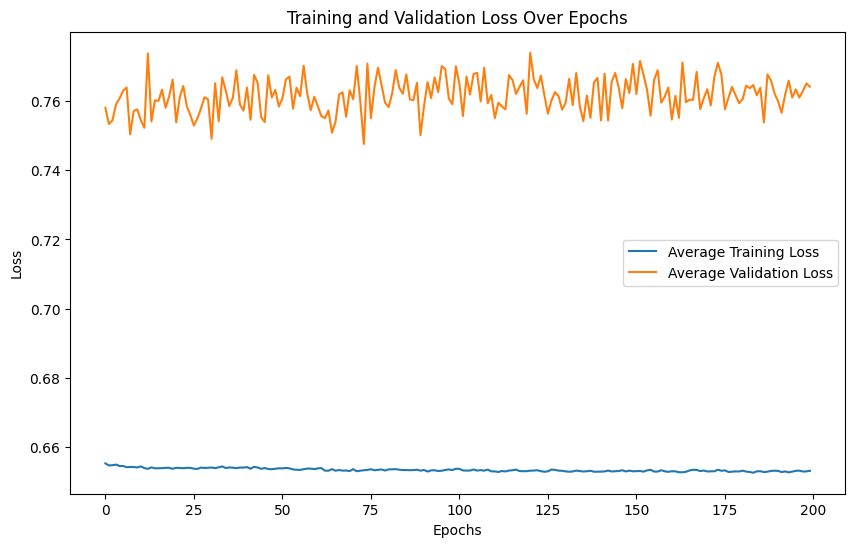

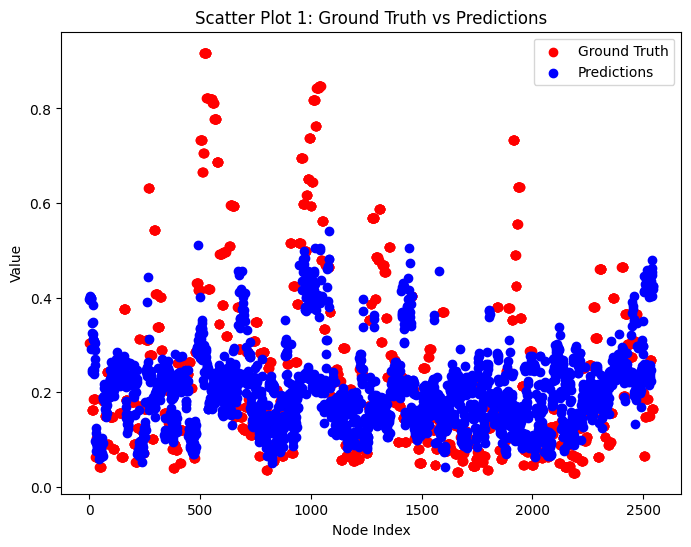

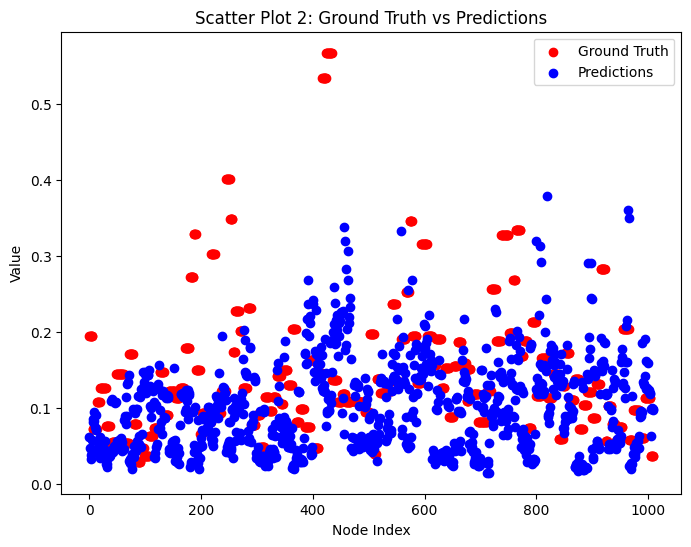

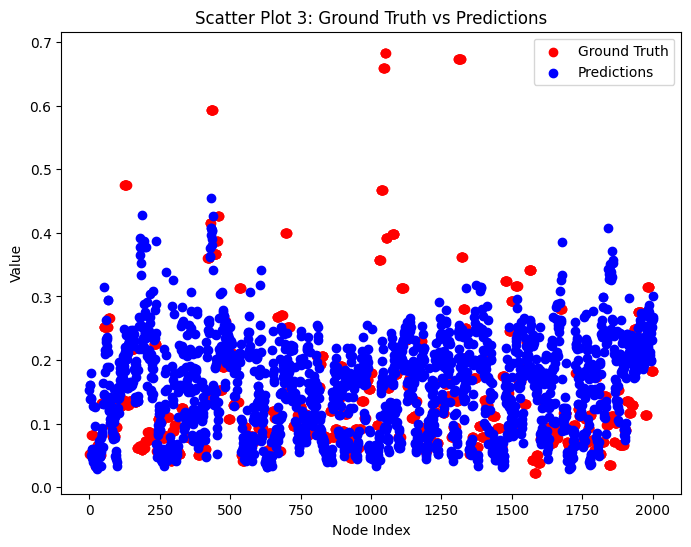

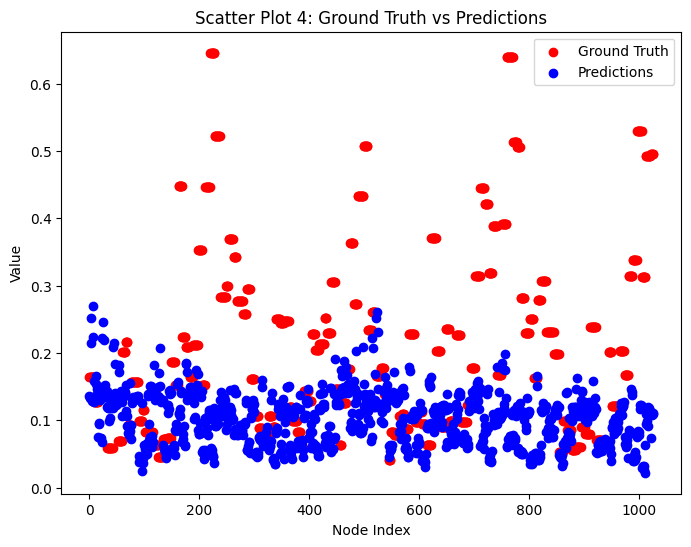

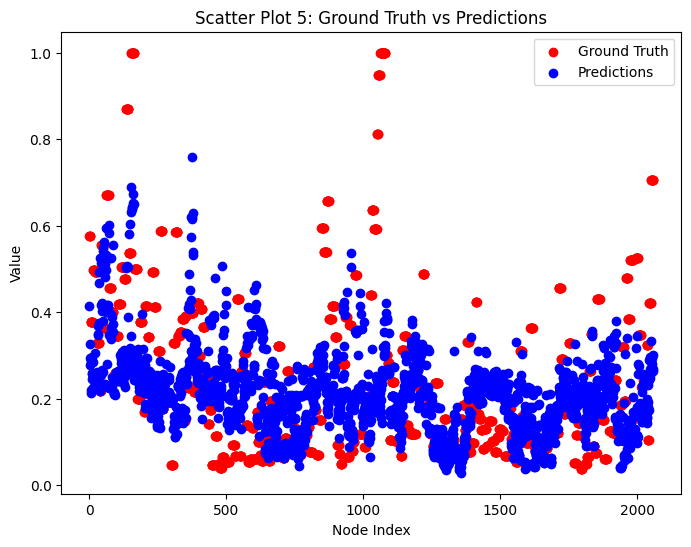

In [1]:
import os
import shutil
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader
import gvp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
from scipy.stats import pearsonr
from torch_geometric.nn import global_mean_pool
import random


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_graph_data():
   
    saved_graphs_folder = 'saved_graphs2'
    graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]
    datasets = [torch.load(os.path.join(saved_graphs_folder, f)) for f in graph_files]
    return datasets

class GVP_RNN_Model(nn.Module):
    def __init__(self, scalar_feature_indices, vector_feature_indices, node_out_dims, dropout_rate=0.5):
        super(GVP_RNN_Model, self).__init__()
        self.scalar_feature_indices = scalar_feature_indices
        self.vector_feature_indices = vector_feature_indices
        scalar_in = len(scalar_feature_indices)
        vector_in = len(vector_feature_indices) // 3

        node_in_dims = (scalar_in, vector_in)
        self.gvp1 = gvp.GVP(node_in_dims, (node_out_dims, node_out_dims // 3), vector_gate=True, activations=(nn.ReLU(), None))
        self.bn1 = nn.BatchNorm1d(node_out_dims) 
        self.dropout = nn.Dropout(dropout_rate)
        self.gvp2 = gvp.GVP((node_out_dims, node_out_dims // 3), (node_out_dims, node_out_dims // 3), vector_gate=True, activations=(nn.ReLU(), None))
        self.final_linear = nn.Linear(node_out_dims, 1) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, data):
        scalar_x = data.x[:, self.scalar_feature_indices]
        vector_x = data.x[:, self.vector_feature_indices].view(-1, len(self.vector_feature_indices) // 3, 3)

        x = (scalar_x, vector_x)
        x = self.gvp1(x)
        x = (self.bn1(x[0]), x[1])  
        x = (self.dropout(x[0]), x[1])
        
        x = self.gvp2(x)
        x = self.final_linear(x[0])  
        
        x = self.sigmoid(x) 

       
        x = x.squeeze(-1) 

        return x




def correlation_loss(y_pred, y_true):
    y_pred = y_pred.squeeze()
    y_true = y_true.squeeze()
    centered_y_pred = y_pred - torch.mean(y_pred)
    centered_y_true = y_true - torch.mean(y_true)

    cov = torch.sum(centered_y_pred * centered_y_true)
    std_pred = torch.sqrt(torch.sum(centered_y_pred ** 2))
    std_true = torch.sqrt(torch.sum(centered_y_true ** 2))

    denominator = std_pred * std_true
    epsilon = 1e-8
    denominator = torch.clamp(denominator, min=epsilon)

    correlation = cov / denominator
    loss = 1 - correlation
    return loss


def leave_one_out_cross_validation(datasets, model, optimizer, criterion, epochs=200):
    loo = LeaveOneOut()
    all_train_loss_history = []  
    all_val_loss_history = []
    all_predictions = []

    for fold, (train_index, val_index) in enumerate(loo.split(datasets)):
        print(f"Starting Fold {fold+1}/{len(datasets)}")
        train_dataset = [datasets[i] for i in train_index]
        val_dataset = datasets[val_index[0]]

        model.to(device)
        fold_train_loss_history = []  
        fold_val_loss_history = []

        for epoch in tqdm(range(epochs), desc=f"Fold {fold+1}"):
            model.train()
            epoch_train_loss = 0
            
            
            for batch_data in DataLoader(train_dataset, batch_size=1, shuffle=True):
                batch_data = batch_data.to(device)
                optimizer.zero_grad()
                output = model(batch_data)
                loss = criterion(output.squeeze(), batch_data.y.squeeze()) 
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()
                
            fold_train_loss_history.append(epoch_train_loss / len(train_dataset))  

          
            model.eval()
            with torch.no_grad():
                val_data = val_dataset.to(device)
                output = model(val_data)
                val_loss = criterion(output.squeeze(), val_data.y.squeeze())
                fold_val_loss_history.append(val_loss.item())

          
                if epoch == epochs - 1:
                    predictions = output.squeeze().cpu().numpy()  
                    all_predictions.append(predictions)

        all_train_loss_history.append(fold_train_loss_history)
        all_val_loss_history.append(fold_val_loss_history)

    return all_train_loss_history, all_val_loss_history, all_predictions




scalar_feature_indices = [0, 1, 5, 7, 8, 9, 10, 18, 19, 20, 21, 22, 23, 24, 25] #6, 14,15,16,17
vector_feature_indices = [11, 12, 13] #2,3,4
node_out_dims = 32
epochs = 200
batch_size = 64


def save_predictions(ground_truth, predictions, filename):
    with open(filename, 'w') as f:
        f.write("Ground Truth\tPredictions\n")
        for gt, pred in zip(ground_truth, predictions):
            f.write(f"{gt:.6f}\t{pred:.6f}\n")


def create_new_preds_folder():
    if os.path.exists('preds'):
        shutil.rmtree('preds')
    os.mkdir('preds')


datasets = load_graph_data()


model = GVP_RNN_Model(scalar_feature_indices, vector_feature_indices, node_out_dims)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_history, val_loss_history, all_predictions = leave_one_out_cross_validation(
    datasets, model, optimizer, correlation_loss, epochs=epochs
)

avg_train_loss_history = np.mean(train_loss_history, axis=0)
avg_train_loss_history = np.mean(train_loss_history, axis=0)
avg_val_loss_history = np.mean(val_loss_history, axis=0)

def safe_max(values):
    valid_values = [v for v in values if np.isfinite(v)]
    return max(valid_values) if valid_values else 0

plt.figure(figsize=(10, 6))
plt.plot(np.mean(train_loss_history, axis=0), label='Average Training Loss')
plt.plot(np.mean(val_loss_history, axis=0), label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

create_new_preds_folder()

for i, predictions in enumerate(all_predictions):
    ground_truth = datasets[i].y.cpu().numpy()
    if len(predictions) != len(ground_truth):
        print(f"Warning: Mismatch in dataset {i}. Predictions: {len(predictions)}, Ground Truths: {len(ground_truth)}")
        continue 
    filename = os.path.join('preds', f'protein_{i}_predictions.txt')
    save_predictions(ground_truth, predictions, filename)



random_indices = random.sample(range(len(datasets)), min(5, len(datasets)))
for i, index in enumerate(random_indices, 1):
    ground_truth = datasets[index].y.cpu().numpy()
    predictions = all_predictions[index]

    plt.figure(figsize=(8, 6))
    plt.scatter(np.arange(len(ground_truth)), ground_truth, color='red', label='Ground Truth')
    plt.scatter(np.arange(len(predictions)), predictions, color='blue', label='Predictions')
    plt.xlabel('Node Index')
    plt.ylabel('Value')
    plt.title(f'Scatter Plot {i}: Ground Truth vs Predictions')
    plt.legend()
    plt.show()



Starting Fold 1/129


Fold 1:   0%|          | 0/200 [00:00<?, ?it/s]

Fold 1: 100%|██████████| 200/200 [04:36<00:00,  1.38s/it]


Starting Fold 2/129


Fold 2: 100%|██████████| 200/200 [04:25<00:00,  1.33s/it]


Starting Fold 3/129


Fold 3: 100%|██████████| 200/200 [04:26<00:00,  1.33s/it]


Starting Fold 4/129


Fold 4: 100%|██████████| 200/200 [04:33<00:00,  1.37s/it]


Starting Fold 5/129


Fold 5: 100%|██████████| 200/200 [04:29<00:00,  1.35s/it]


Starting Fold 6/129


Fold 6: 100%|██████████| 200/200 [04:23<00:00,  1.32s/it]


Starting Fold 7/129


Fold 7: 100%|██████████| 200/200 [04:20<00:00,  1.30s/it]


Starting Fold 8/129


Fold 8: 100%|██████████| 200/200 [04:15<00:00,  1.28s/it]


Starting Fold 9/129


Fold 9: 100%|██████████| 200/200 [04:22<00:00,  1.31s/it]


Starting Fold 10/129


Fold 10: 100%|██████████| 200/200 [04:17<00:00,  1.29s/it]


Starting Fold 11/129


Fold 11: 100%|██████████| 200/200 [04:17<00:00,  1.29s/it]


Starting Fold 12/129


Fold 12: 100%|██████████| 200/200 [04:16<00:00,  1.28s/it]


Starting Fold 13/129


Fold 13: 100%|██████████| 200/200 [04:15<00:00,  1.28s/it]


Starting Fold 14/129


Fold 14: 100%|██████████| 200/200 [04:16<00:00,  1.28s/it]


Starting Fold 15/129


Fold 15: 100%|██████████| 200/200 [04:16<00:00,  1.28s/it]


Starting Fold 16/129


Fold 16: 100%|██████████| 200/200 [04:18<00:00,  1.29s/it]


Starting Fold 17/129


Fold 17: 100%|██████████| 200/200 [04:16<00:00,  1.28s/it]


Starting Fold 18/129


Fold 18: 100%|██████████| 200/200 [04:17<00:00,  1.29s/it]


Starting Fold 19/129


Fold 19: 100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Starting Fold 20/129


Fold 20: 100%|██████████| 200/200 [02:33<00:00,  1.30it/s]


Starting Fold 21/129


Fold 21: 100%|██████████| 200/200 [02:33<00:00,  1.31it/s]


Starting Fold 22/129


Fold 22: 100%|██████████| 200/200 [02:34<00:00,  1.29it/s]


Starting Fold 23/129


Fold 23: 100%|██████████| 200/200 [02:31<00:00,  1.32it/s]


Starting Fold 24/129


Fold 24: 100%|██████████| 200/200 [02:31<00:00,  1.32it/s]


Starting Fold 25/129


Fold 25: 100%|██████████| 200/200 [02:31<00:00,  1.32it/s]


Starting Fold 26/129


Fold 26: 100%|██████████| 200/200 [02:31<00:00,  1.32it/s]


Starting Fold 27/129


Fold 27: 100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


Starting Fold 28/129


Fold 28: 100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


Starting Fold 29/129


Fold 29: 100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


Starting Fold 30/129


Fold 30: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 31/129


Fold 31: 100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


Starting Fold 32/129


Fold 32: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 33/129


Fold 33: 100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


Starting Fold 34/129


Fold 34: 100%|██████████| 200/200 [02:33<00:00,  1.30it/s]


Starting Fold 35/129


Fold 35: 100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


Starting Fold 36/129


Fold 36: 100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


Starting Fold 37/129


Fold 37: 100%|██████████| 200/200 [02:30<00:00,  1.32it/s]


Starting Fold 38/129


Fold 38: 100%|██████████| 200/200 [02:29<00:00,  1.33it/s]


Starting Fold 39/129


Fold 39: 100%|██████████| 200/200 [02:31<00:00,  1.32it/s]


Starting Fold 40/129


Fold 40: 100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


Starting Fold 41/129


Fold 41: 100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


Starting Fold 42/129


Fold 42: 100%|██████████| 200/200 [02:29<00:00,  1.33it/s]


Starting Fold 43/129


Fold 43: 100%|██████████| 200/200 [02:29<00:00,  1.33it/s]


Starting Fold 44/129


Fold 44: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 45/129


Fold 45: 100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


Starting Fold 46/129


Fold 46: 100%|██████████| 200/200 [02:32<00:00,  1.31it/s]


Starting Fold 47/129


Fold 47: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 48/129


Fold 48: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 49/129


Fold 49: 100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


Starting Fold 50/129


Fold 50: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 51/129


Fold 51: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 52/129


Fold 52: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 53/129


Fold 53: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 54/129


Fold 54: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 55/129


Fold 55: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 56/129


Fold 56: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 57/129


Fold 57: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 58/129


Fold 58: 100%|██████████| 200/200 [02:32<00:00,  1.31it/s]


Starting Fold 59/129


Fold 59: 100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


Starting Fold 60/129


Fold 60: 100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


Starting Fold 61/129


Fold 61: 100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


Starting Fold 62/129


Fold 62: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 63/129


Fold 63: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 64/129


Fold 64: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 65/129


Fold 65: 100%|██████████| 200/200 [02:29<00:00,  1.33it/s]


Starting Fold 66/129


Fold 66: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 67/129


Fold 67: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 68/129


Fold 68: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 69/129


Fold 69: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 70/129


Fold 70: 100%|██████████| 200/200 [02:32<00:00,  1.31it/s]


Starting Fold 71/129


Fold 71: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 72/129


Fold 72: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 73/129


Fold 73: 100%|██████████| 200/200 [02:29<00:00,  1.33it/s]


Starting Fold 74/129


Fold 74: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 75/129


Fold 75: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 76/129


Fold 76: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 77/129


Fold 77: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 78/129


Fold 78: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 79/129


Fold 79: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 80/129


Fold 80: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 81/129


Fold 81: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 82/129


Fold 82: 100%|██████████| 200/200 [02:31<00:00,  1.32it/s]


Starting Fold 83/129


Fold 83: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 84/129


Fold 84: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 85/129


Fold 85: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 86/129


Fold 86: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 87/129


Fold 87: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 88/129


Fold 88: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 89/129


Fold 89: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 90/129


Fold 90: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 91/129


Fold 91: 100%|██████████| 200/200 [02:31<00:00,  1.32it/s]


Starting Fold 92/129


Fold 92: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 93/129


Fold 93: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 94/129


Fold 94: 100%|██████████| 200/200 [02:31<00:00,  1.32it/s]


Starting Fold 95/129


Fold 95: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 96/129


Fold 96: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 97/129


Fold 97: 100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


Starting Fold 98/129


Fold 98: 100%|██████████| 200/200 [02:27<00:00,  1.35it/s]


Starting Fold 99/129


Fold 99: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 100/129


Fold 100: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 101/129


Fold 101: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 102/129


Fold 102: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 103/129


Fold 103: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 104/129


Fold 104: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 105/129


Fold 105: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 106/129


Fold 106: 100%|██████████| 200/200 [02:31<00:00,  1.32it/s]


Starting Fold 107/129


Fold 107: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 108/129


Fold 108: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 109/129


Fold 109: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 110/129


Fold 110: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 111/129


Fold 111: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 112/129


Fold 112: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 113/129


Fold 113: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 114/129


Fold 114: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 115/129


Fold 115: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 116/129


Fold 116: 100%|██████████| 200/200 [02:27<00:00,  1.35it/s]


Starting Fold 117/129


Fold 117: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 118/129


Fold 118: 100%|██████████| 200/200 [02:32<00:00,  1.31it/s]


Starting Fold 119/129


Fold 119: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 120/129


Fold 120: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 121/129


Fold 121: 100%|██████████| 200/200 [02:29<00:00,  1.34it/s]


Starting Fold 122/129


Fold 122: 100%|██████████| 200/200 [02:35<00:00,  1.29it/s]


Starting Fold 123/129


Fold 123: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 124/129


Fold 124: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 125/129


Fold 125: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 126/129


Fold 126: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 127/129


Fold 127: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


Starting Fold 128/129


Fold 128: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


Starting Fold 129/129


Fold 129: 100%|██████████| 200/200 [02:28<00:00,  1.34it/s]


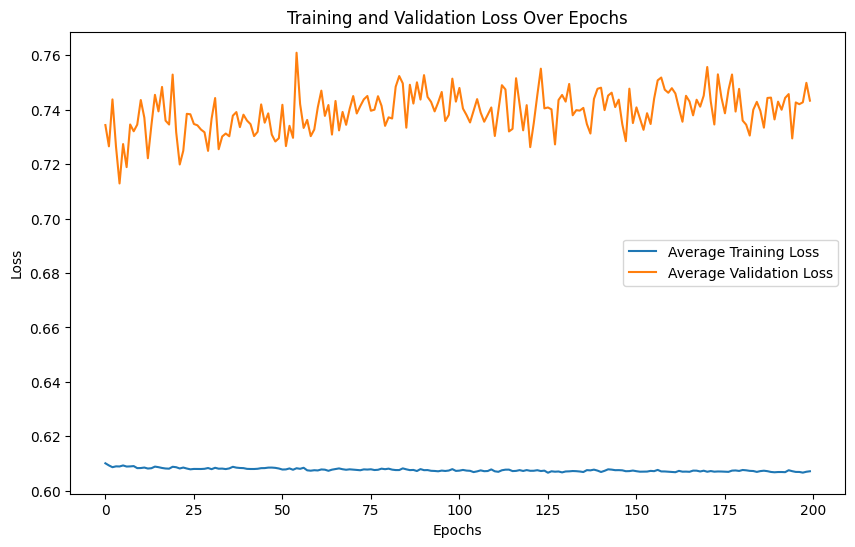

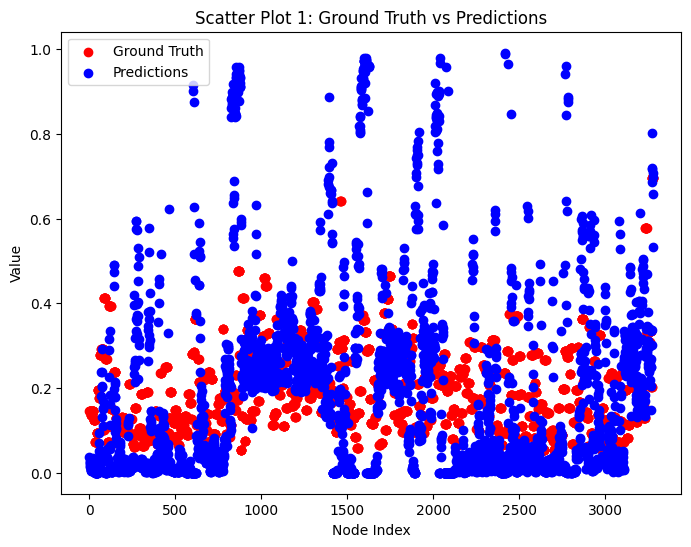

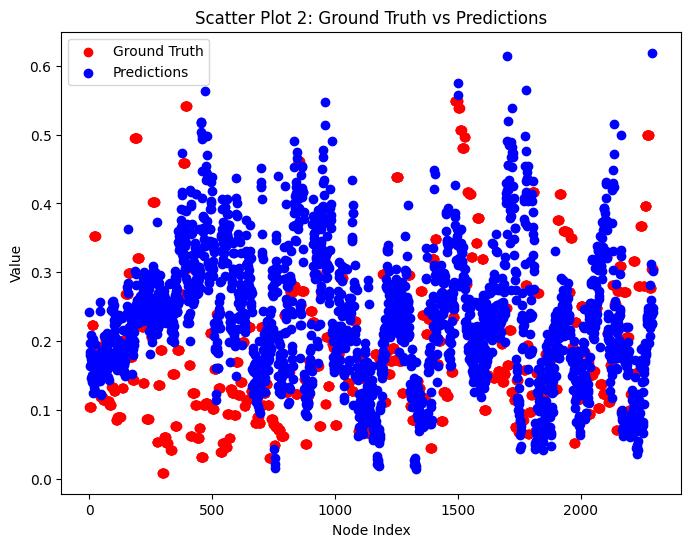

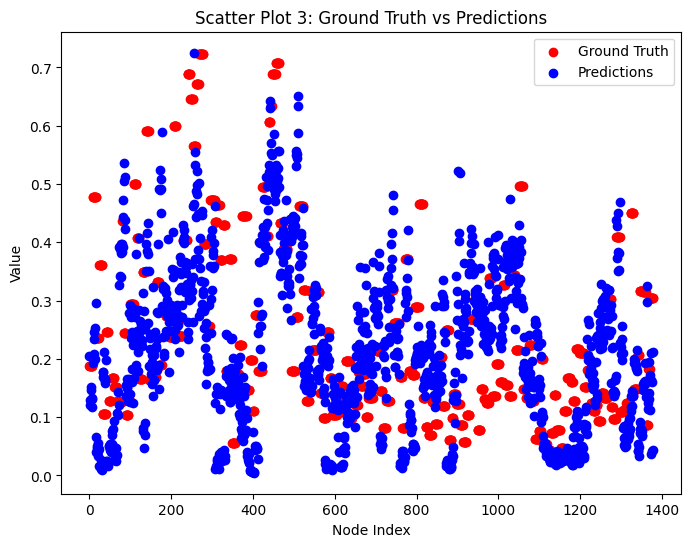

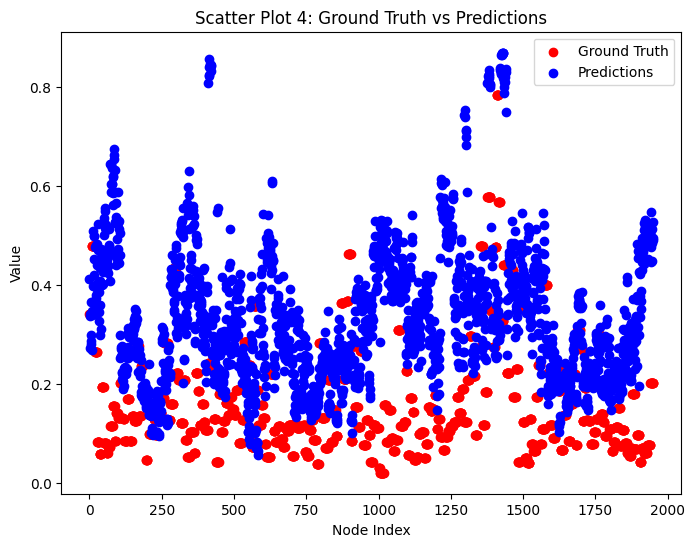

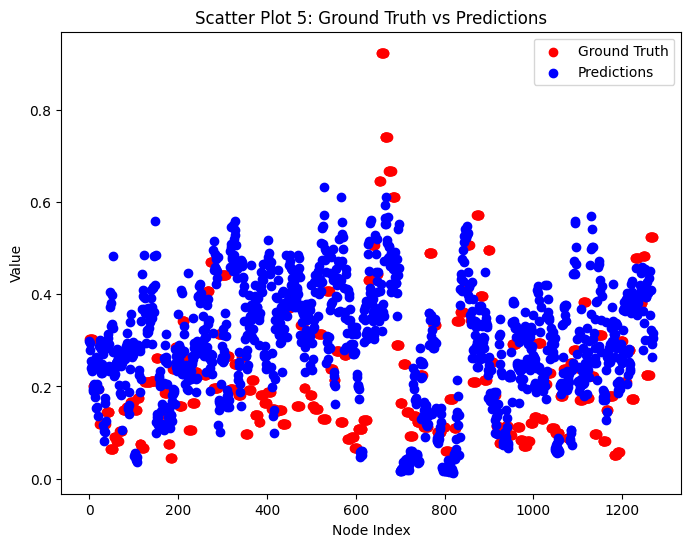

In [ ]:
import os
import shutil
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader
import gvp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
from scipy.stats import pearsonr
from torch_geometric.nn import global_mean_pool
import random


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_graph_data():
   
    saved_graphs_folder = 'saved_graphs2'
    graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]
    datasets = [torch.load(os.path.join(saved_graphs_folder, f)) for f in graph_files]
    return datasets

class GVP_RNN_Model(nn.Module):
    def __init__(self, scalar_feature_indices, vector_feature_indices, node_out_dims, dropout_rate=0.5):
        super(GVP_RNN_Model, self).__init__()
        self.scalar_feature_indices = scalar_feature_indices
        self.vector_feature_indices = vector_feature_indices
        scalar_in = len(scalar_feature_indices)
        vector_in = len(vector_feature_indices) // 3

        node_in_dims = (scalar_in, vector_in)
        self.gvp1 = gvp.GVP(node_in_dims, (node_out_dims, node_out_dims // 3), vector_gate=True, activations=(nn.ReLU(), None))
        self.bn1 = nn.BatchNorm1d(node_out_dims) 
        self.dropout = nn.Dropout(dropout_rate)
        self.gvp2 = gvp.GVP((node_out_dims, node_out_dims // 3), (node_out_dims, node_out_dims // 3), vector_gate=True, activations=(nn.ReLU(), None))
        self.final_linear = nn.Linear(node_out_dims, 1) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, data):
        scalar_x = data.x[:, self.scalar_feature_indices]
        vector_x = data.x[:, self.vector_feature_indices].view(-1, len(self.vector_feature_indices) // 3, 3)

        x = (scalar_x, vector_x)
        x = self.gvp1(x)
        x = (self.bn1(x[0]), x[1])  
        x = (self.dropout(x[0]), x[1])
        
        x = self.gvp2(x)
        x = self.final_linear(x[0])  
        
        x = self.sigmoid(x) 

       
        x = x.squeeze(-1) 

        return x




def correlation_loss(y_pred, y_true):
    y_pred = y_pred.squeeze()
    y_true = y_true.squeeze()
    centered_y_pred = y_pred - torch.mean(y_pred)
    centered_y_true = y_true - torch.mean(y_true)

    cov = torch.sum(centered_y_pred * centered_y_true)
    std_pred = torch.sqrt(torch.sum(centered_y_pred ** 2))
    std_true = torch.sqrt(torch.sum(centered_y_true ** 2))

    denominator = std_pred * std_true
    epsilon = 1e-8
    denominator = torch.clamp(denominator, min=epsilon)

    correlation = cov / denominator
    loss = 1 - correlation
    return loss


def leave_one_out_cross_validation(datasets, model, optimizer, criterion, epochs=200):
    loo = LeaveOneOut()
    all_train_loss_history = []
    all_val_loss_history = []
    all_predictions = []

   
    for fold, (train_index, val_index) in enumerate(loo.split(datasets)):
        print(f"Starting Fold {fold+1}/{len(datasets)}")
        train_dataset = [datasets[i] for i in train_index]
        val_dataset = datasets[val_index[0]]

        model.to(device)
        fold_train_loss_history = []
        fold_val_loss_history = []

      
        for epoch in tqdm(range(epochs), desc=f"Fold {fold+1}"):
            model.train()
            epoch_train_loss = 0
            for batch_data in DataLoader(train_dataset, batch_size=1, shuffle=True):
                batch_data = batch_data.to(device)
                optimizer.zero_grad()
                output = model(batch_data)
                loss = criterion(output.squeeze(), batch_data.y.squeeze()) 
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()
            fold_train_loss_history.append(epoch_train_loss / len(train_dataset))

         
            model.eval()
            with torch.no_grad():
                val_data = val_dataset.to(device)
                output = model(val_data)
                val_loss = criterion(output.squeeze(), val_data.y.squeeze())
                fold_val_loss_history.append(val_loss.item())

               
                if epoch == epochs - 1:
                    predictions = output.squeeze().cpu().numpy()  
                    all_predictions.append(predictions)

        all_train_loss_history.append(fold_train_loss_history)
        all_val_loss_history.append(fold_val_loss_history)

    return all_train_loss_history, all_val_loss_history, all_predictions



scalar_feature_indices = [0, 1, 5, 7, 8, 9, 10, 18, 19, 20, 21, 22, 23, 24, 25, 6, 14, 15, 16, 17]
vector_feature_indices = [11, 12, 13, 2, 3, 4]
node_out_dims = 32
epochs = 200
batch_size = 64


def save_predictions(ground_truth, predictions, filename):
    with open(filename, 'w') as f:
        f.write("Ground Truth\tPredictions\n")
        for gt, pred in zip(ground_truth, predictions):
            f.write(f"{gt:.6f}\t{pred:.6f}\n")


def create_new_preds_folder():
    if os.path.exists('preds'):
        shutil.rmtree('preds')
    os.mkdir('preds')


datasets = load_graph_data()


model = GVP_RNN_Model(scalar_feature_indices, vector_feature_indices, node_out_dims)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_history, val_loss_history, all_predictions = leave_one_out_cross_validation(
    datasets, model, optimizer, correlation_loss, epochs=epochs
)

avg_train_loss_history = np.mean(train_loss_history, axis=0)
avg_val_loss_history = np.mean(val_loss_history, axis=0)
avg_test_loss_history = np.mean(test_loss_history, axis=0)

def safe_max(values):
    valid_values = [v for v in values if np.isfinite(v)]
    return max(valid_values) if valid_values else 0

plt.figure(figsize=(10, 6))
plt.plot(np.mean(train_loss_history, axis=0), label='Average Training Loss')
plt.plot(np.mean(val_loss_history, axis=0), label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

create_new_preds_folder()

for i, predictions in enumerate(all_predictions):
    ground_truth = datasets[i].y.cpu().numpy()
    if len(predictions) != len(ground_truth):
        print(f"Warning: Mismatch in dataset {i}. Predictions: {len(predictions)}, Ground Truths: {len(ground_truth)}")
        continue 
    filename = os.path.join('preds', f'protein_{i}_predictions.txt')
    save_predictions(ground_truth, predictions, filename)


# Display 5 random scatter plots
random_indices = random.sample(range(len(datasets)), min(5, len(datasets)))
for i, index in enumerate(random_indices, 1):
    ground_truth = datasets[index].y.cpu().numpy()
    predictions = all_predictions[index]

    plt.figure(figsize=(8, 6))
    plt.scatter(np.arange(len(ground_truth)), ground_truth, color='red', label='Ground Truth')
    plt.scatter(np.arange(len(predictions)), predictions, color='blue', label='Predictions')
    plt.xlabel('Node Index')
    plt.ylabel('Value')
    plt.title(f'Scatter Plot {i}: Ground Truth vs Predictions')
    plt.legend()
    plt.show()



/tmp/ipykernel_2490/2198003028.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=20, c=colors, cmap='coolwarm')


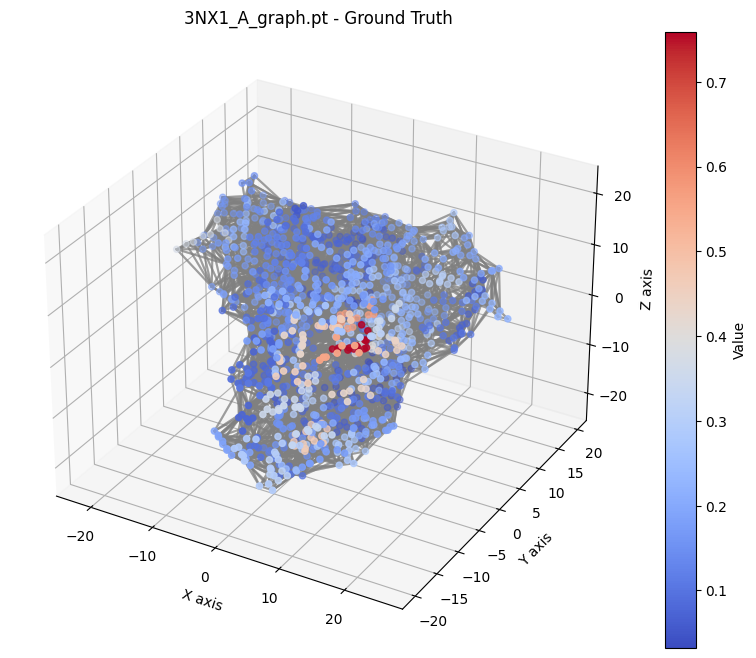

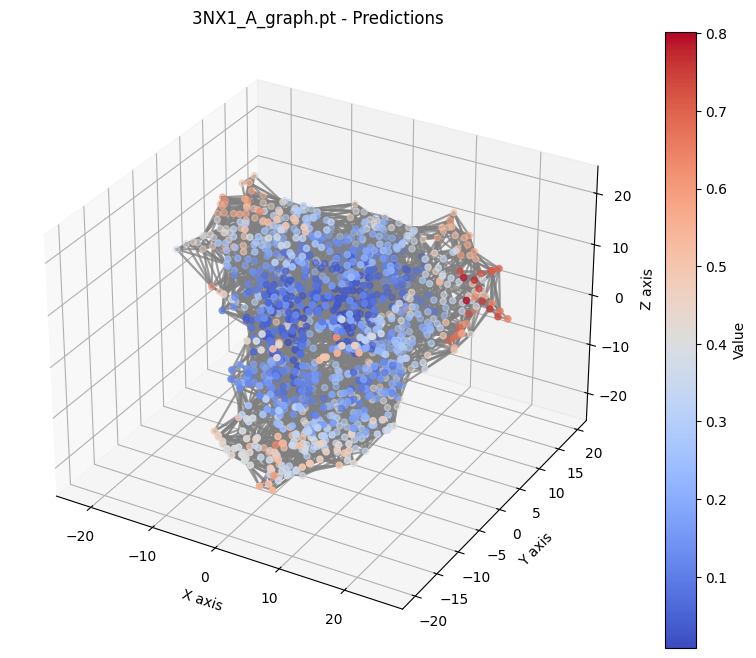

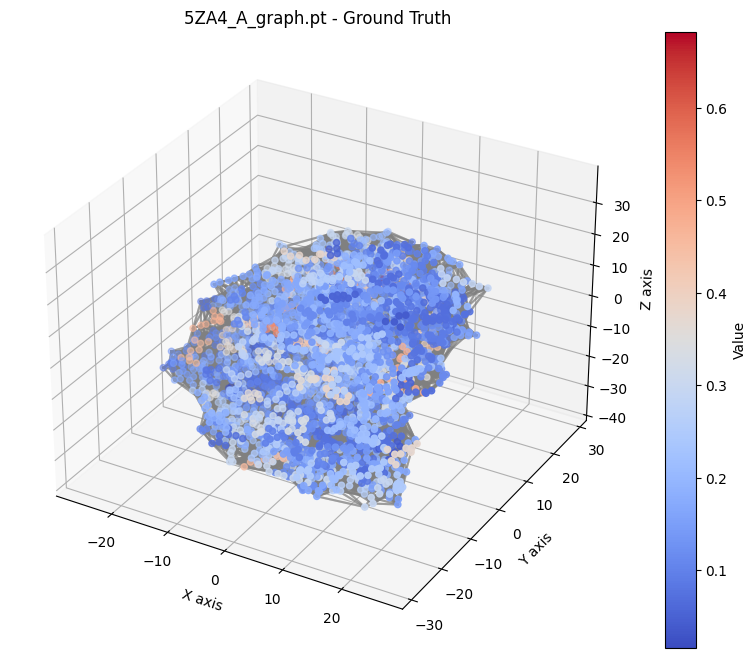

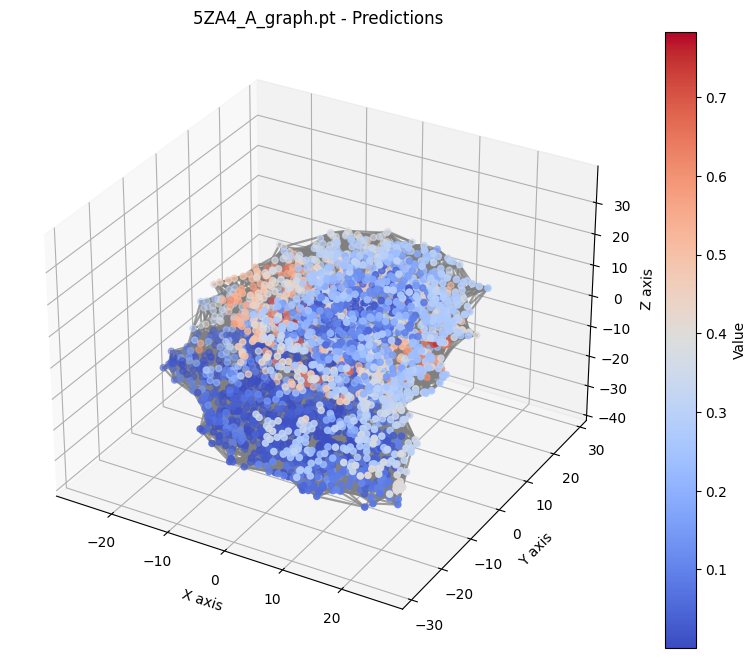

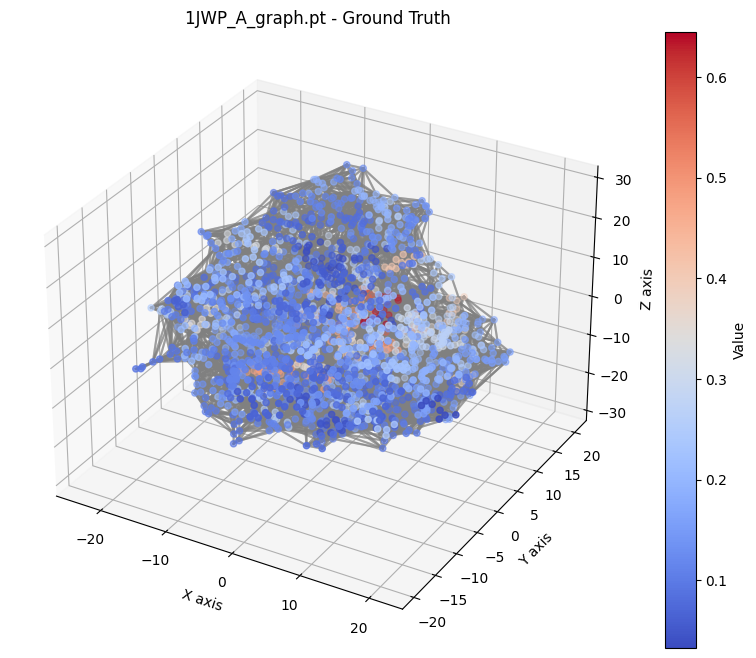

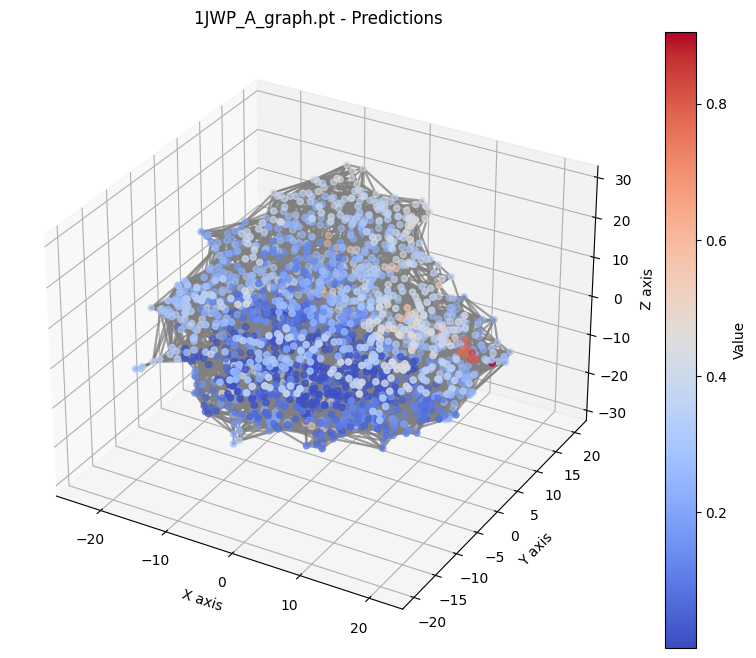

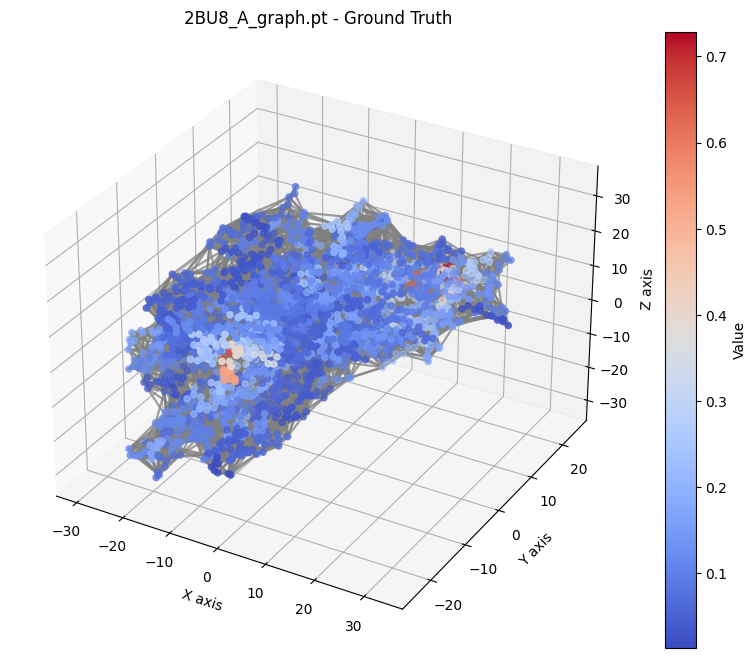

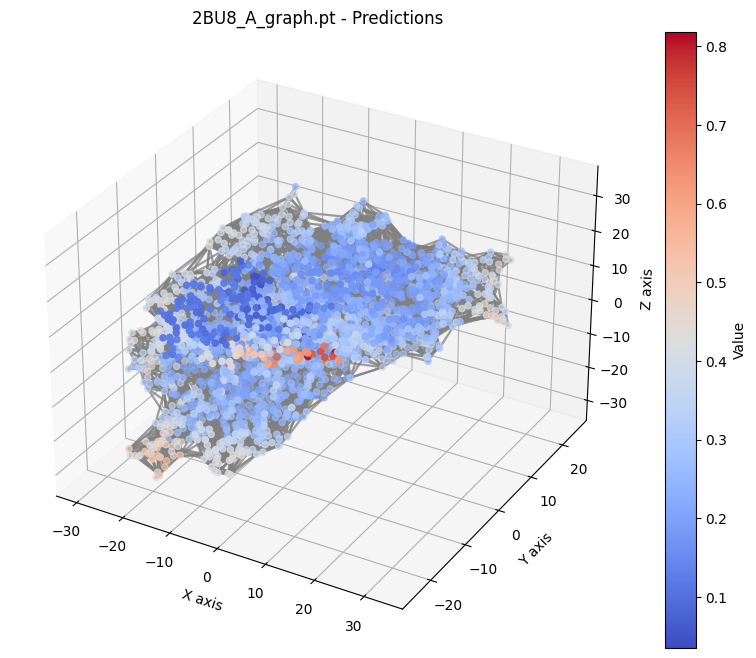

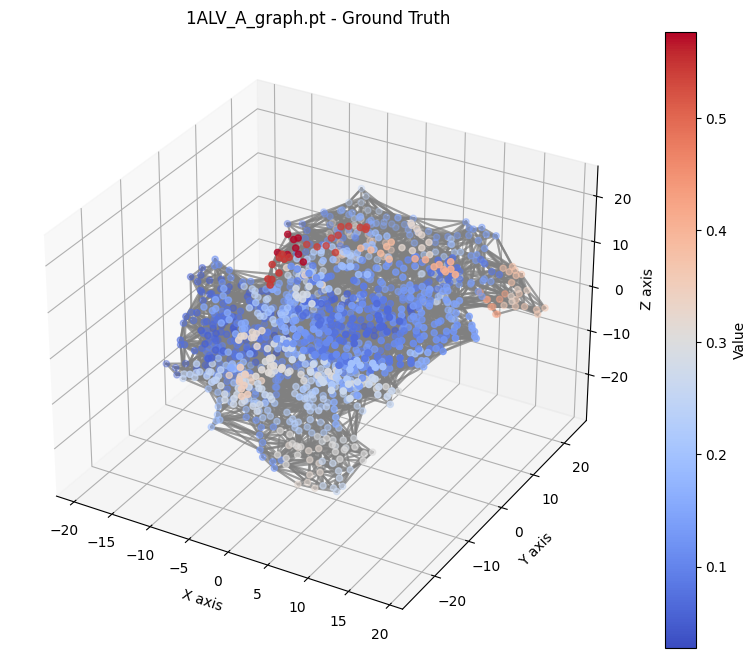

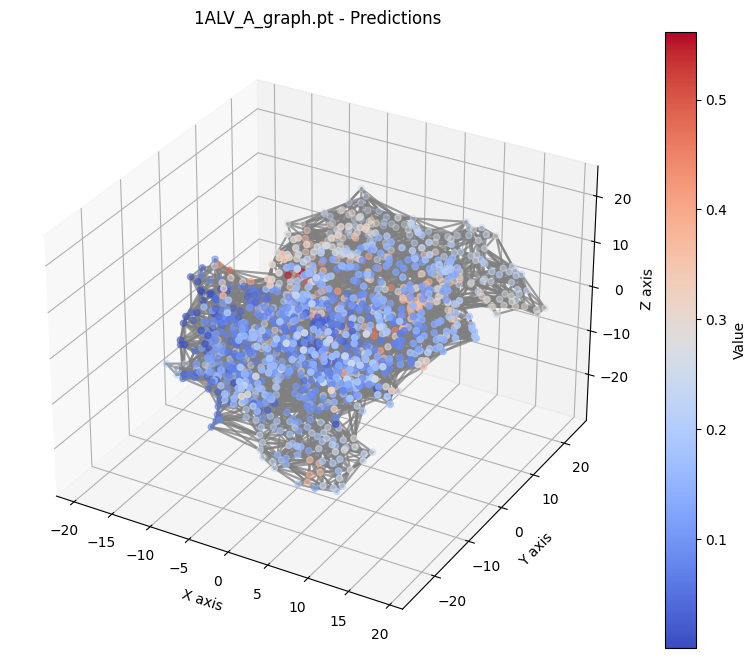

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def load_graph_and_truth(file_path):
    graph = torch.load(file_path)
    ground_truth = graph.y.cpu().numpy() 
    return graph, ground_truth

def load_only_predictions(file_path):
    predictions = []
    with open(file_path, 'r') as f:
        next(f)  
        for line in f:
            _, pred = line.strip().split('\t')
            predictions.append(float(pred))
    return np.array(predictions)

def plot_protein_graph(graph, node_values, title="Protein Graph Visualization"):
    pos = graph.x[:, 2:5].cpu().numpy()
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    norm = plt.Normalize(vmin=node_values.min(), vmax=node_values.max())
    cmap = plt.get_cmap('coolwarm')
    colors = cmap(norm(node_values))
    
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=20, c=colors, cmap='coolwarm')
    
    if hasattr(graph, 'edge_index'):
        for start, end in graph.edge_index.t().cpu().numpy():
            xs, ys, zs = zip(pos[start], pos[end])
            ax.plot(xs, ys, zs, color='gray', alpha=0.5)
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Value')
    
    plt.title(title)
    plt.show()


saved_graphs_folder = 'saved_graphs2'
preds_folder = 'preds'


graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]


random_indices = np.random.choice(len(graph_files), 5, replace=False)

for idx in random_indices:
    graph_file_path = os.path.join(saved_graphs_folder, graph_files[idx])
    pred_file_path = os.path.join(preds_folder, f"protein_{idx}_predictions.txt")
    

    graph, ground_truth = load_graph_and_truth(graph_file_path)
    
 
    predictions = load_only_predictions(pred_file_path)
    
  
    plot_protein_graph(graph, ground_truth, title=f"{graph_files[idx]} - Ground Truth")
    

    plot_protein_graph(graph, predictions, title=f"{graph_files[idx]} - Predictions")


Fold 129: 100%|██████████| 200/200 [01:12<00:00,  2.75it/s]


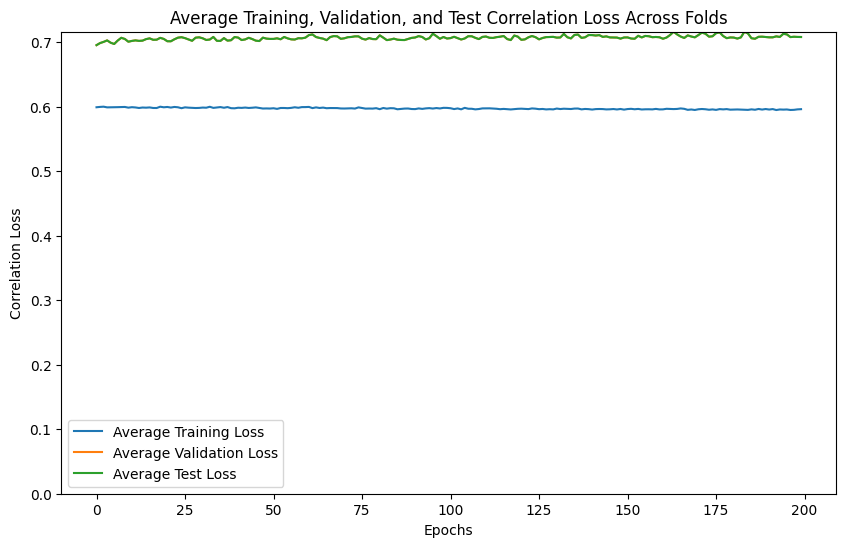

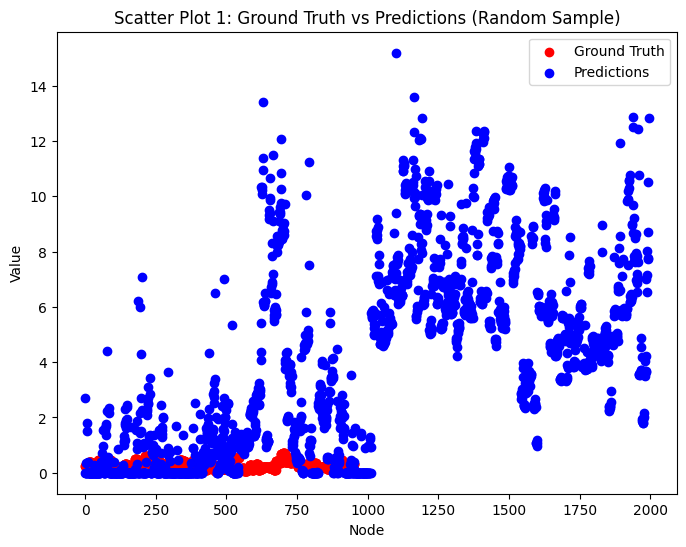

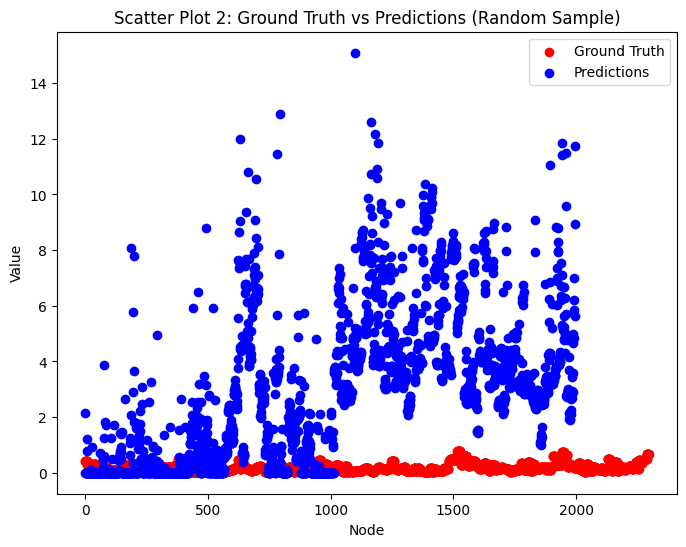

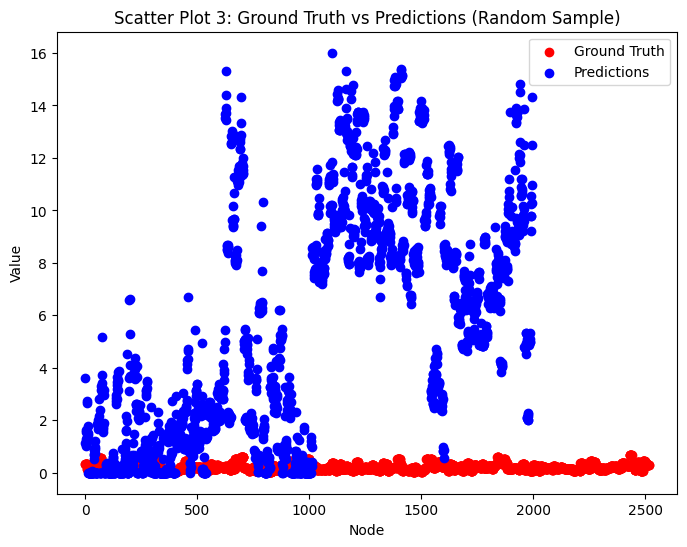

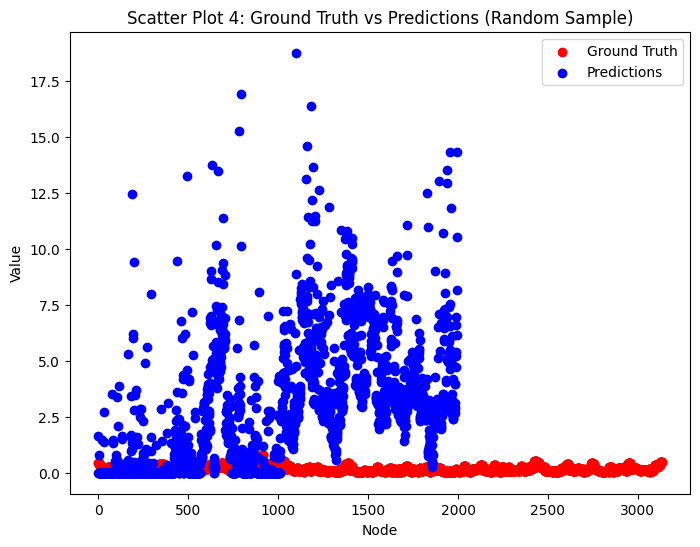

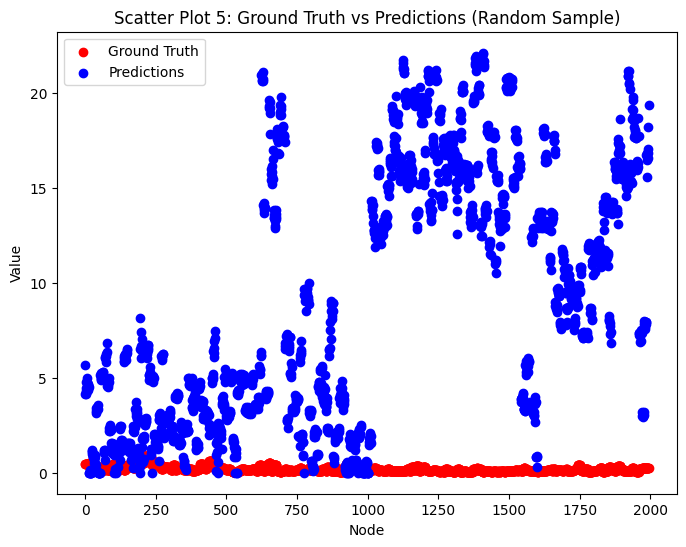

In [ ]:
import os
import shutil
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader
import gvp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
from scipy.stats import pearsonr
import random


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_graph_data():

    saved_graphs_folder = 'saved_graphs2'
    graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]
    datasets = [torch.load(os.path.join(saved_graphs_folder, f)) for f in graph_files]
    return datasets


class GVP_RNN_Model(nn.Module):
    def __init__(self, scalar_feature_indices, vector_feature_indices, node_out_dims, dropout_rate=0.5):
        super(GVP_RNN_Model, self).__init__()
        self.scalar_feature_indices = scalar_feature_indices
        self.vector_feature_indices = vector_feature_indices
        scalar_in = len(scalar_feature_indices)
        vector_in = len(vector_feature_indices) // 3

        node_in_dims = (scalar_in, vector_in)
        self.gvp1 = gvp.GVP(node_in_dims, (node_out_dims, node_out_dims // 3), vector_gate=True, activations=(nn.ReLU(), None))
        self.dropout = nn.Dropout(dropout_rate)
        self.gvp2 = gvp.GVP((node_out_dims, node_out_dims // 3), (1, 0))

    def forward(self, data):
        scalar_x = data.x[:, self.scalar_feature_indices]
        vector_x = data.x[:, self.vector_feature_indices].view(-1, len(self.vector_feature_indices) // 3, 3)

        x = (scalar_x, vector_x)
        x = self.gvp1(x)
        x = self.dropout(x[0]), x[1]
        x = self.gvp2(x)


        if x[0].shape[0] == data.x.shape[0]:
            x = geom_nn.global_mean_pool(x[0], data.batch)
        return x


def correlation_loss(y_pred, y_true):
    centered_y_pred = y_pred - torch.mean(y_pred)
    centered_y_true = y_true - torch.mean(y_true)

    denominator = torch.sqrt(torch.sum(centered_y_pred ** 2)) * torch.sqrt(torch.sum(centered_y_true ** 2))
    epsilon = 1e-8
    denominator = torch.clamp(denominator, min=epsilon)

    correlation = torch.sum(centered_y_pred * centered_y_true) / denominator

    loss = 1 - correlation
    return loss


def leave_one_out_cross_validation(datasets, model, optimizer, criterion, batch_size=64):
    loo = LeaveOneOut()

    all_train_loss_history = []
    all_val_loss_history = []
    all_test_loss_history = []
    all_predictions = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for fold, (train_index, val_index) in enumerate(loo.split(datasets)):
        train_data = [datasets[i] for i in train_index]
        val_data = datasets[val_index[0]]

        model.to(device)
        model.train()

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader([val_data], batch_size=batch_size, shuffle=False)

        train_loss_history = []
        val_loss_history = []
        test_loss_history = []

        for epoch in tqdm(range(epochs), desc=f"Fold {fold+1}"):
            total_train_loss = 0


            model.train()
            for batch_data in train_loader:
                batch_data = batch_data.to(device)
                optimizer.zero_grad()
                output = model(batch_data)

                output = output.squeeze()
                loss = criterion(output, batch_data.y)

                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            train_loss_history.append(avg_train_loss)

     
            model.eval()
            with torch.no_grad():
                total_val_loss = 0
                for batch_data in val_loader:
                    batch_data = batch_data.to(device)
                    output = model(batch_data)
                    output = output.squeeze()
                    loss = criterion(output, batch_data.y)
                    total_val_loss += loss.item()
                avg_val_loss = total_val_loss / len(val_loader)
                val_loss_history.append(avg_val_loss)

           
            test_data_loader = DataLoader([val_data], batch_size=1, shuffle=False)
            total_test_loss = 0
            predictions = []
            model.eval()
            with torch.no_grad():
                for batch_data in test_data_loader:
                    batch_data = batch_data.to(device)
                    output = model(batch_data)
                    output = output.squeeze()
                    loss = criterion(output, batch_data.y)
                    total_test_loss += loss.item()
                    predictions.append(output.cpu().numpy())
                avg_test_loss = total_test_loss / len(test_data_loader)
                test_loss_history.append(avg_test_loss)
            
            all_predictions.append(predictions)

        all_train_loss_history.append(train_loss_history)
        all_val_loss_history.append(val_loss_history)
        all_test_loss_history.append(test_loss_history)

    return all_train_loss_history, all_val_loss_history, all_test_loss_history, all_predictions


scalar_feature_indices = [0, 1, 5, 7, 8, 9, 10, 18, 19, 20, 21, 22, 23, 24, 25, 6, 14, 15, 16, 17]
vector_feature_indices = [11, 12, 13, 2, 3, 4]
node_out_dims = 32
epochs = 200
batch_size = 64


def save_predictions(ground_truth, predictions, filename):
    with open(filename, 'w') as f:
        f.write("Ground Truth\tPredictions\n")
        for gt, pred in zip(ground_truth, predictions):
            f.write(f"{gt:.6f}\t{pred:.6f}\n")


def create_new_preds_folder():
    if os.path.exists('preds'):
        shutil.rmtree('preds')
    os.mkdir('preds')


datasets = load_graph_data()


model = GVP_RNN_Model(scalar_feature_indices, vector_feature_indices, node_out_dims)
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_loss_history, val_loss_history, test_loss_history, all_predictions = leave_one_out_cross_validation(datasets, model, optimizer, correlation_loss, batch_size=batch_size)


avg_train_loss_history = np.mean(train_loss_history, axis=0)
avg_val_loss_history = np.mean(val_loss_history, axis=0)
avg_test_loss_history = np.mean(test_loss_history, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(avg_train_loss_history, label='Average Training Loss')
plt.plot(avg_val_loss_history, label='Average Validation Loss')
plt.plot(avg_test_loss_history, label='Average Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Correlation Loss')
plt.title('Average Training, Validation, and Test Correlation Loss Across Folds')
plt.legend()
plt.ylim(0, max(max(avg_train_loss_history), max(avg_val_loss_history), max(avg_test_loss_history)))
plt.show()


create_new_preds_folder()


for i, predictions in enumerate(all_predictions):
    if i < len(datasets): 
        ground_truth = datasets[i].y.cpu().numpy()
        filename = os.path.join('preds', f'protein_{i}_predictions.txt')
        save_predictions(ground_truth, predictions[-1], filename)


random_indices = random.sample(range(len(datasets)), min(5, len(datasets)))
for i, index in enumerate(random_indices, 1):
    ground_truth = datasets[index].y.cpu().numpy()
    predictions = all_predictions[index][-1] 

    plt.figure(figsize=(8, 6))
    plt.scatter(range(len(ground_truth)), ground_truth, color='red', label='Ground Truth')
    plt.scatter(range(len(predictions)), predictions, color='blue', label='Predictions')
    plt.xlabel('Node')
    plt.ylabel('Value')
    plt.title(f'Scatter Plot {i}: Ground Truth vs Predictions (Random Sample)')
    plt.legend()
    plt.show()


# MSE

In [ ]:
import os
import shutil
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader
import gvp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
from scipy.stats import pearsonr
from torch_geometric.nn import global_mean_pool
import random


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_graph_data():

    saved_graphs_folder = 'saved_graphs2'
    graph_files = [f for f in os.listdir(saved_graphs_folder) if f.endswith('.pt')]
    datasets = [torch.load(os.path.join(saved_graphs_folder, f)) for f in graph_files]
    return datasets

class GVP_RNN_Model(nn.Module):
    def __init__(self, scalar_feature_indices, vector_feature_indices, node_out_dims, dropout_rate=0.5):
        super(GVP_RNN_Model, self).__init__()
        self.scalar_feature_indices = scalar_feature_indices
        self.vector_feature_indices = vector_feature_indices
        scalar_in = len(scalar_feature_indices)
        vector_in = len(vector_feature_indices) // 3

        node_in_dims = (scalar_in, vector_in)
        self.gvp1 = gvp.GVP(node_in_dims, (node_out_dims, node_out_dims // 3), vector_gate=True, activations=(nn.ReLU(), None))
        self.bn1 = nn.BatchNorm1d(node_out_dims) 
        self.dropout = nn.Dropout(dropout_rate)
        self.gvp2 = gvp.GVP((node_out_dims, node_out_dims // 3), (node_out_dims, node_out_dims // 3), vector_gate=True, activations=(nn.ReLU(), None))
        self.final_linear = nn.Linear(node_out_dims, 1)  
        self.sigmoid = nn.Sigmoid()

    def forward(self, data):
        scalar_x = data.x[:, self.scalar_feature_indices]
        vector_x = data.x[:, self.vector_feature_indices].view(-1, len(self.vector_feature_indices) // 3, 3)

        x = (scalar_x, vector_x)
        x = self.gvp1(x)
        x = (self.bn1(x[0]), x[1]) 
        x = (self.dropout(x[0]), x[1])
        
        x = self.gvp2(x)
        x = self.final_linear(x[0])
        
        x = self.sigmoid(x) 

        
        x = x.squeeze(-1) 

        return x




def correlation_loss(y_pred, y_true):
    y_pred = y_pred.squeeze()
    y_true = y_true.squeeze()
    centered_y_pred = y_pred - torch.mean(y_pred)
    centered_y_true = y_true - torch.mean(y_true)

    cov = torch.sum(centered_y_pred * centered_y_true)
    std_pred = torch.sqrt(torch.sum(centered_y_pred ** 2))
    std_true = torch.sqrt(torch.sum(centered_y_true ** 2))

    denominator = std_pred * std_true
    epsilon = 1e-8
    denominator = torch.clamp(denominator, min=epsilon)

    correlation = cov / denominator
    loss = 1 - correlation
    return loss

def l1_regularization(model, lambda_l1=0.001):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return lambda_l1 * l1_norm

def combined_loss(output, target, model, lambda_l1=0.001):

    mse_loss = torch.nn.functional.mse_loss(output, target)
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    total_loss = mse_loss + (lambda_l1 * l1_norm)
    return total_loss


def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()


def leave_one_out_cross_validation(datasets, model, optimizer_func, epochs=200, device='cpu', lambda_l1=0.001):
    """
    Performs leave-one-out cross-validation.
    """
    from sklearn.model_selection import LeaveOneOut
    loo = LeaveOneOut()
    all_predictions = []
    all_ground_truths = []
    fold_train_losses = []
    fold_val_losses = []

    for fold, (train_index, val_index) in enumerate(loo.split(datasets)):
        
        train_dataset = [datasets[i] for i in train_index]
        val_dataset = datasets[val_index[0]].to(device)

        
        model.apply(reset_weights)
        model.to(device)
        optimizer = optimizer_func(model.parameters())  
        epoch_train_losses = []
        for epoch in tqdm(range(epochs), desc=f"Fold {fold+1}"):
            model.train()
            total_train_loss = 0.0
            for batch_data in DataLoader(train_dataset, batch_size=1, shuffle=True):
                batch_data = batch_data.to(device)
                optimizer.zero_grad()
                output = model(batch_data)
                loss = combined_loss(output.view(-1), batch_data.y.view(-1), model, lambda_l1)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
            avg_train_loss = total_train_loss / len(train_dataset)
            epoch_train_losses.append(avg_train_loss)

       
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            output = model(val_dataset)
            val_loss = combined_loss(output.view(-1), val_dataset.y.view(-1), model, lambda_l1)
            total_val_loss += val_loss.item()

        fold_train_losses.append(np.mean(epoch_train_losses))
        fold_val_losses.append(total_val_loss / len(val_dataset))

        predictions = output.squeeze().cpu().numpy()
        ground_truths = val_dataset.y.cpu().numpy()
        all_predictions.append(predictions)
        all_ground_truths.append(ground_truths)

        
        print(f"Fold {fold+1} Average Train Loss: {np.mean(epoch_train_losses):.4f}, Val Loss: {total_val_loss:.4f}")

    return all_predictions, all_ground_truths, fold_train_losses, fold_val_losses




scalar_feature_indices = [0, 1, 5, 7, 8, 9, 10, 18, 19, 20, 21, 22, 23, 24, 25, 6, 14, 15, 16, 17]
vector_feature_indices = [11, 12, 13, 2, 3, 4]
node_out_dims = 32
epochs = 5
batch_size = 64


def save_predictions(ground_truth, predictions, filename):
    with open(filename, 'w') as f:
        f.write("Ground Truth\tPredictions\n")
        for gt, pred in zip(ground_truth, predictions):
            f.write(f"{gt:.6f}\t{pred:.6f}\n")


def create_new_preds_folder():
    if os.path.exists('preds'):
        shutil.rmtree('preds')
    os.mkdir('preds')


datasets = load_graph_data()


model = GVP_RNN_Model(scalar_feature_indices, vector_feature_indices, node_out_dims)
optimizer = optim.Adam(model.parameters(), lr=0.001)


def optimizer_func(params):
    return optim.Adam(params, lr=0.001)


all_predictions, all_ground_truths, fold_train_losses, fold_val_losses = leave_one_out_cross_validation(
    datasets=datasets, 
    model=model, 
    optimizer_func=optimizer_func, 
    epochs=5, 
    device=device, 
    lambda_l1=0.001
)




avg_train_loss_history = np.mean(fold_train_losses, axis=0)


avg_val_loss_history = np.mean(fold_val_losses, axis=0)


avg_test_loss_history = np.mean(test_loss_history, axis=0)

def safe_max(values):
    valid_values = [v for v in values if np.isfinite(v)]
    return max(valid_values) if valid_values else 0


avg_train_loss = np.mean(fold_train_losses)
avg_val_loss = np.mean(fold_val_losses)

plt.figure(figsize=(10, 6))
plt.plot(fold_train_losses, label='Fold Average Training Loss')
plt.plot(fold_val_losses, label='Fold Average Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Fold Average Training and Validation Loss')
plt.legend()
plt.show()


create_new_preds_folder()

for i, predictions in enumerate(all_predictions):
    ground_truth = datasets[i].y.cpu().numpy()
    if len(predictions) != len(ground_truth):
        print(f"Warning: Mismatch in dataset {i}. Predictions: {len(predictions)}, Ground Truths: {len(ground_truth)}")
        continue  
    filename = os.path.join('preds', f'protein_{i}_predictions.txt')
    save_predictions(ground_truth, predictions, filename)



random_indices = random.sample(range(len(datasets)), min(5, len(datasets)))
for i, index in enumerate(random_indices, 1):
    ground_truth = datasets[index].y.cpu().numpy()
    predictions = all_predictions[index]

    plt.figure(figsize=(8, 6))
    plt.scatter(np.arange(len(ground_truth)), ground_truth, color='red', label='Ground Truth')
    plt.scatter(np.arange(len(predictions)), predictions, color='blue', label='Predictions')
    plt.xlabel('Node Index')
    plt.ylabel('Value')
    plt.title(f'Scatter Plot {i}: Ground Truth vs Predictions')
    plt.legend()
    plt.show()



Fold 1: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


Fold 1 Average Train Loss: 0.1182, Val Loss: 0.0587


Fold 2: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Fold 2 Average Train Loss: 0.1118, Val Loss: 0.0552


Fold 3: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


Fold 3 Average Train Loss: 0.1165, Val Loss: 0.0534


Fold 4: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]


Fold 4 Average Train Loss: 0.1175, Val Loss: 0.0488


Fold 5: 100%|██████████| 5/5 [00:12<00:00,  2.49s/it]


Fold 5 Average Train Loss: 0.1158, Val Loss: 0.0684


Fold 6: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]


Fold 6 Average Train Loss: 0.1097, Val Loss: 0.0576


Fold 7: 100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


Fold 7 Average Train Loss: 0.1203, Val Loss: 0.0433


Fold 8: 100%|██████████| 5/5 [00:20<00:00,  4.17s/it]


Fold 8 Average Train Loss: 0.1245, Val Loss: 0.0537


Fold 9: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]


Fold 9 Average Train Loss: 0.1159, Val Loss: 0.0635


Fold 10: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Fold 10 Average Train Loss: 0.1161, Val Loss: 0.0736


Fold 11: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


Fold 11 Average Train Loss: 0.1148, Val Loss: 0.0531


Fold 12: 100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


Fold 12 Average Train Loss: 0.1097, Val Loss: 0.0410


Fold 13: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Fold 13 Average Train Loss: 0.1191, Val Loss: 0.0488


Fold 14: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]


Fold 14 Average Train Loss: 0.1206, Val Loss: 0.1086


Fold 15: 100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


Fold 15 Average Train Loss: 0.1166, Val Loss: 0.0540


Fold 16: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


Fold 16 Average Train Loss: 0.1181, Val Loss: 0.0463


Fold 17: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


Fold 17 Average Train Loss: 0.1306, Val Loss: 0.0522


Fold 18: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


Fold 18 Average Train Loss: 0.1219, Val Loss: 0.0800


Fold 19: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Fold 19 Average Train Loss: 0.1093, Val Loss: 0.0481


Fold 20: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Fold 20 Average Train Loss: 0.1172, Val Loss: 0.0489


Fold 21: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Fold 21 Average Train Loss: 0.1086, Val Loss: 0.0403


Fold 22: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Fold 22 Average Train Loss: 0.1120, Val Loss: 0.1097


Fold 23: 100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Fold 23 Average Train Loss: 0.1190, Val Loss: 0.0487


Fold 24: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


Fold 24 Average Train Loss: 0.1166, Val Loss: 0.0504


Fold 25: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Fold 25 Average Train Loss: 0.1192, Val Loss: 0.0460


Fold 26: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


Fold 26 Average Train Loss: 0.1262, Val Loss: 0.0761


Fold 27: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


Fold 27 Average Train Loss: 0.1149, Val Loss: 0.0619


Fold 28: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]


Fold 28 Average Train Loss: 0.1065, Val Loss: 0.0529


Fold 29: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Fold 29 Average Train Loss: 0.1221, Val Loss: 0.0653


Fold 30: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]


Fold 30 Average Train Loss: 0.1127, Val Loss: 0.0470


Fold 31: 100%|██████████| 5/5 [00:21<00:00,  4.23s/it]


Fold 31 Average Train Loss: 0.1152, Val Loss: 0.0702


Fold 32: 100%|██████████| 5/5 [00:17<00:00,  3.58s/it]


Fold 32 Average Train Loss: 0.1096, Val Loss: 0.0441


Fold 33: 100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


Fold 33 Average Train Loss: 0.1221, Val Loss: 0.0470


Fold 34: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


Fold 34 Average Train Loss: 0.1404, Val Loss: 0.0700


Fold 35: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


Fold 35 Average Train Loss: 0.1170, Val Loss: 0.0452


Fold 36: 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]


Fold 36 Average Train Loss: 0.1147, Val Loss: 0.0706


Fold 37: 100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


Fold 37 Average Train Loss: 0.1201, Val Loss: 0.0937


Fold 38: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Fold 38 Average Train Loss: 0.1106, Val Loss: 0.0444


Fold 39: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Fold 39 Average Train Loss: 0.1174, Val Loss: 0.0567


Fold 40: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


Fold 40 Average Train Loss: 0.1260, Val Loss: 0.0578


Fold 41: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Fold 41 Average Train Loss: 0.1279, Val Loss: 0.0608


Fold 42: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Fold 42 Average Train Loss: 0.1146, Val Loss: 0.0742


Fold 43: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Fold 43 Average Train Loss: 0.1149, Val Loss: 0.0592


Fold 44: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Fold 44 Average Train Loss: 0.1174, Val Loss: 0.0585


Fold 45: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Fold 45 Average Train Loss: 0.1244, Val Loss: 0.0586


Fold 46: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


Fold 46 Average Train Loss: 0.1202, Val Loss: 0.0553


Fold 47: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Fold 47 Average Train Loss: 0.1211, Val Loss: 0.0452


Fold 48: 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Fold 48 Average Train Loss: 0.1233, Val Loss: 0.0537


Fold 49: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Fold 49 Average Train Loss: 0.1146, Val Loss: 0.0768


Fold 50: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


Fold 50 Average Train Loss: 0.1197, Val Loss: 0.0553


Fold 51: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Fold 51 Average Train Loss: 0.1245, Val Loss: 0.0513


Fold 52: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Fold 52 Average Train Loss: 0.1211, Val Loss: 0.0577


Fold 53: 100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Fold 53 Average Train Loss: 0.1174, Val Loss: 0.0439


Fold 54: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


Fold 54 Average Train Loss: 0.1071, Val Loss: 0.0499


Fold 55: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Fold 55 Average Train Loss: 0.1117, Val Loss: 0.0371


Fold 56: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Fold 56 Average Train Loss: 0.1171, Val Loss: 0.0457


Fold 57: 100%|██████████| 5/5 [00:08<00:00,  1.75s/it]


Fold 57 Average Train Loss: 0.1184, Val Loss: 0.0725


Fold 58: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Fold 58 Average Train Loss: 0.1117, Val Loss: 0.0691


Fold 59: 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]


Fold 59 Average Train Loss: 0.1140, Val Loss: 0.0565


Fold 60: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


Fold 60 Average Train Loss: 0.1113, Val Loss: 0.0454


Fold 61: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


Fold 61 Average Train Loss: 0.1159, Val Loss: 0.0489


Fold 62: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Fold 62 Average Train Loss: 0.1197, Val Loss: 0.0485


Fold 63: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


Fold 63 Average Train Loss: 0.1204, Val Loss: 0.0619


Fold 64: 100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


Fold 64 Average Train Loss: 0.1158, Val Loss: 0.0418


Fold 65: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


Fold 65 Average Train Loss: 0.1151, Val Loss: 0.0458


Fold 66: 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


Fold 66 Average Train Loss: 0.1143, Val Loss: 0.0566


Fold 67: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


Fold 67 Average Train Loss: 0.1148, Val Loss: 0.0506


Fold 68: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Fold 68 Average Train Loss: 0.1252, Val Loss: 0.0748


Fold 69: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Fold 69 Average Train Loss: 0.1166, Val Loss: 0.0683


Fold 70: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Fold 70 Average Train Loss: 0.1191, Val Loss: 0.0689


Fold 71: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Fold 71 Average Train Loss: 0.1166, Val Loss: 0.0699


Fold 72: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Fold 72 Average Train Loss: 0.1185, Val Loss: 0.0552


Fold 73: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Fold 73 Average Train Loss: 0.1165, Val Loss: 0.0467


Fold 74: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Fold 74 Average Train Loss: 0.1179, Val Loss: 0.0520


Fold 75: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Fold 75 Average Train Loss: 0.1196, Val Loss: 0.0515


Fold 76: 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


Fold 76 Average Train Loss: 0.1167, Val Loss: 0.0558


Fold 77: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Fold 77 Average Train Loss: 0.1196, Val Loss: 0.0580


Fold 78: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Fold 78 Average Train Loss: 0.1290, Val Loss: 0.0670


Fold 79: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Fold 79 Average Train Loss: 0.1176, Val Loss: 0.0477


Fold 80: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Fold 80 Average Train Loss: 0.1225, Val Loss: 0.0657


Fold 81: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Fold 81 Average Train Loss: 0.1215, Val Loss: 0.0586


Fold 82: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Fold 82 Average Train Loss: 0.1094, Val Loss: 0.0429


Fold 83: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Fold 83 Average Train Loss: 0.1157, Val Loss: 0.0465


Fold 84: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Fold 84 Average Train Loss: 0.1155, Val Loss: 0.0424


Fold 85: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Fold 85 Average Train Loss: 0.1205, Val Loss: 0.0481


Fold 86: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Fold 86 Average Train Loss: 0.1171, Val Loss: 0.0786


Fold 87: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Fold 87 Average Train Loss: 0.1287, Val Loss: 0.0711


Fold 88: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Fold 88 Average Train Loss: 0.1118, Val Loss: 0.0474


Fold 89: 100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Fold 89 Average Train Loss: 0.1154, Val Loss: 0.0448


Fold 90: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Fold 90 Average Train Loss: 0.1182, Val Loss: 0.0593


Fold 91: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Fold 91 Average Train Loss: 0.1193, Val Loss: 0.0593


Fold 92: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Fold 92 Average Train Loss: 0.1213, Val Loss: 0.0523


Fold 93: 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]


Fold 93 Average Train Loss: 0.1207, Val Loss: 0.1362


Fold 94: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Fold 94 Average Train Loss: 0.1124, Val Loss: 0.0556


Fold 95: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Fold 95 Average Train Loss: 0.1206, Val Loss: 0.0472


Fold 96: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Fold 96 Average Train Loss: 0.1263, Val Loss: 0.0690


Fold 97: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


Fold 97 Average Train Loss: 0.1230, Val Loss: 0.0479


Fold 98: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Fold 98 Average Train Loss: 0.1211, Val Loss: 0.0536


Fold 99: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Fold 99 Average Train Loss: 0.1178, Val Loss: 0.0549


Fold 100: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Fold 100 Average Train Loss: 0.1138, Val Loss: 0.0502


Fold 101: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Fold 101 Average Train Loss: 0.1250, Val Loss: 0.0487


Fold 102: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Fold 102 Average Train Loss: 0.1053, Val Loss: 0.0464


Fold 103: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Fold 103 Average Train Loss: 0.1164, Val Loss: 0.0517


Fold 104: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Fold 104 Average Train Loss: 0.1199, Val Loss: 0.0477


Fold 105: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Fold 105 Average Train Loss: 0.1197, Val Loss: 0.0583


Fold 106: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Fold 106 Average Train Loss: 0.1172, Val Loss: 0.0737


Fold 107: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Fold 107 Average Train Loss: 0.1117, Val Loss: 0.0439


Fold 108: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Fold 108 Average Train Loss: 0.1186, Val Loss: 0.0613


Fold 109: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Fold 109 Average Train Loss: 0.1225, Val Loss: 0.0816


Fold 110: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Fold 110 Average Train Loss: 0.1223, Val Loss: 0.0509


Fold 111: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Fold 111 Average Train Loss: 0.1178, Val Loss: 0.0427


Fold 112: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


Fold 112 Average Train Loss: 0.1265, Val Loss: 0.0541


Fold 113: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Fold 113 Average Train Loss: 0.1230, Val Loss: 0.0580


Fold 114: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Fold 114 Average Train Loss: 0.1192, Val Loss: 0.0621


Fold 115: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Fold 115 Average Train Loss: 0.1194, Val Loss: 0.0558


Fold 116: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Fold 116 Average Train Loss: 0.1167, Val Loss: 0.0592


Fold 117: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Fold 117 Average Train Loss: 0.1058, Val Loss: 0.0689


Fold 118: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Fold 118 Average Train Loss: 0.1074, Val Loss: 0.0421


Fold 119: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Fold 119 Average Train Loss: 0.1230, Val Loss: 0.0469


Fold 120: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Fold 120 Average Train Loss: 0.1093, Val Loss: 0.0459


Fold 121: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Fold 121 Average Train Loss: 0.1250, Val Loss: 0.0516


Fold 122: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Fold 122 Average Train Loss: 0.1149, Val Loss: 0.1266


Fold 123: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Fold 123 Average Train Loss: 0.1269, Val Loss: 0.0509


Fold 124: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Fold 124 Average Train Loss: 0.1269, Val Loss: 0.0501


Fold 125: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


Fold 125 Average Train Loss: 0.1183, Val Loss: 0.0719


Fold 126: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Fold 126 Average Train Loss: 0.1130, Val Loss: 0.0462


Fold 127: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Fold 127 Average Train Loss: 0.1129, Val Loss: 0.0510


Fold 128: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


Fold 128 Average Train Loss: 0.1220, Val Loss: 0.0592


Fold 129: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]

Fold 129 Average Train Loss: 0.1127, Val Loss: 0.0507


NameError: name 'train_loss_history' is not defined